In [1]:
import sys
sys.path.append('/SEE-MTDA/see')
from sc.mesher.mesher import Mesher
import numpy as np
import os
import glob
from pathlib import Path
from sc.datasets.shared_utils import *
import open3d as o3d
from easydict import EasyDict
import yaml
from PIL import Image

def cfg_from_yaml_file(cfg_file):
    cfg = EasyDict()
    print("\n----- Cfgs -----")
    with open(cfg_file, 'r') as f:
        yaml_config = yaml.safe_load(f)
        print(yaml.dump(yaml_config))

    cfg.update(EasyDict(yaml_config))

    return cfg

cfg_file = '/SEE-MTDA/see/sc/cfgs/WAY-DM-ORH005.yaml'
cfg = cfg_from_yaml_file(cfg_file)
mesher = Mesher(cfg=cfg, cfg_path=cfg_file)

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.

----- Cfgs -----
DATASET:
  CAMERA_CHANNELS:
  - FRONT
  CLASSES:
  - Vehicle
  DET2D_MASK: false
  DET2D_MODEL: htc
  NAME: waymo
  POINT_CLOUD_RANGE:
  - -70
  - -70
  - -2
  - 70
  - 70
  - 4
  UPDATE_GT_DATABASE: false
DATA_PATH: /SEE-MTDA/data/waymo/custom_1000
MESHER:
  CLUSTERING:
    EPS_SCALING: 5
    NAME: db_scan
  MESH_ALGORITHM:
    LOWER_RADIUS: 0.01
    NAME: ball_pivoting
    UPPER_RADIUS: 1.155
  MIN_LIDAR_PTS_TO_MESH: 50
  NAME: gt_mesh
  REPLACE_OBJECT_WITH_MESH:
    POINT_DISTANCE_THRESH: 0.1
  SAMPLING:
    NAME: vres_ring_based_sampling
    OPTIMAL_RING_HEIGHT: 0.05
    TYPE: poisson
  VRES: 0.3125


Mesher Initialised!


In [18]:
import os
import shutil

image_pc_dirs = glob.glob(str(mesher.data_obj.root_dir / 'waymo_processed_data/*/image_pc'))
for file_path in image_pc_dirs:
    if os.path.exists(file_path):
        # removing the file using the os.remove() method
        shutil.rmtree(file_path)
    else:
        # file not found message
        print("File not found in the directory")

In [24]:
# Create new dataset split

import tensorflow.compat.v1 as tf
import math
import itertools
from tqdm import trange
tf.enable_eager_execution()
from waymo_open_dataset.utils import range_image_utils
from waymo_open_dataset.utils import transform_utils
from waymo_open_dataset.utils import  frame_utils
from waymo_open_dataset import dataset_pb2 as open_dataset
from PIL import Image

CAMERA_CHANNELS = ['FRONT','FRONT_LEFT','FRONT_RIGHT','SIDE_LEFT','SIDE_RIGHT']
t = trange(len(mesher.data_obj), desc='Waymo', leave=True)

# For each frame, save the pointcloud (npy), pts_img (npy), diff channel img (png)
for frame_idx in t:
    idx = 100
    record_name = mesher.data_obj.get_infos(frame_idx)['point_cloud']['lidar_sequence']
    record_fname = mesher.data_obj.root_dir.parent / 'raw_data' / f"{record_name}.tfrecord"
    if not record_fname.exists():
        print(f"{record_fname} does not exist")
        break

    try:
        record = tf.data.TFRecordDataset(str(record_fname), compression_type='')
    except Exception as e:
        print(e)

    # This iteration takes a long time
    for f_idx, data in enumerate(record):
        if f_idx == idx:     
            frame = open_dataset.Frame()
            frame.ParseFromString(bytearray(data.numpy()))
            break

    save_dir = mesher.data_obj.root_dir / 'waymo_processed_data' / record_name
    save_dir.mkdir(parents=True, exist_ok=True)
    
    t.set_description(f"{record_name}")
    t.refresh() # to show immediately the update
    
    for camera_channel in CAMERA_CHANNELS:
        imgfov = mesher.data_obj.map_pointcloud_to_image(frame, camera_channel)
                
        image_pc_dir = save_dir / 'image_pc'
        image_pc_dir.mkdir(parents=True, exist_ok=True)
        np.save(str(image_pc_dir / f'{idx:04}_{camera_channel}.npy'), imgfov['pts_img'])                

        img = mesher.data_obj.get_image_from_frame(frame, camera_channel)
        image_dir = save_dir / 'image'
        image_dir.mkdir(parents=True, exist_ok=True)
        Image.fromarray(np.uint8(img)).save(str(image_dir / f'{idx:04}_{camera_channel}.png'))

segment-9443948810903981522_6538_870_6558_870_with_camera_labels: 100%|█| 1000/


In [139]:
import time

t0 = time.time()
imgfov = mesher.data_obj.map_pointcloud_to_image(frame, 'FRONT')
print(time.time() - t0)

0.6011505126953125


In [126]:
imgfov['pc_lidar']

array([[ 3.0579346e+01,  1.3310791e+01,  3.7173462e+00],
       [ 3.0578979e+01,  1.3227051e+01,  3.7161865e+00],
       [ 3.0594116e+01,  1.3150635e+01,  3.7158813e+00],
       ...,
       [ 9.1016378e+00, -1.8466945e+00,  3.5556316e-02],
       [ 9.0729589e+00, -2.0934708e+00,  3.0648708e-02],
       [ 9.0507364e+00, -2.3431354e+00,  2.3021340e-02]], dtype=float32)

In [41]:
import pickle

with open('/SEE-MTDA/data/waymo/custom_1000/waymo_processed_data/segment-15832924468527961_1564_160_1584_160_with_camera_labels/segment-15832924468527961_1564_160_1584_160_with_camera_labels.pkl', 'rb') as f:
    data = pickle.load(f)

In [73]:
points, cp_points = mesher.data_obj.get_pointcloud_from_frame(frame)

In [76]:
cp_points_all_concat = np.concatenate([cp_points, points], axis=-1)
cp_points_all_concat_tensor = tf.constant(cp_points_all_concat)

In [108]:
cp_points_all_tensor = tf.constant(cp_points, dtype=tf.int32)
cp_points_all_tensor

<tf.Tensor: id=11772, shape=(152466, 6), dtype=int32, numpy=
array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]], dtype=int32)>

In [114]:
np.unique(cp_points_all_tensor[...,1:3])

array([   0,    1,    2, ..., 1917, 1918, 1919], dtype=int32)

In [106]:
mask = tf.equal(cp_points_all_tensor[..., 0], image_record.name)
cp_points_all_tensor = tf.cast(tf.gather_nd(
            cp_points_all_tensor, tf.where(mask)), dtype=tf.float32)

In [117]:
np.unique(imgfov['pts_img'][:,2])

array([ 7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23,
       24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40,
       41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57,
       58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 74, 75,
       76])

In [72]:
image_record = frame.images[0]
image_record.name

1

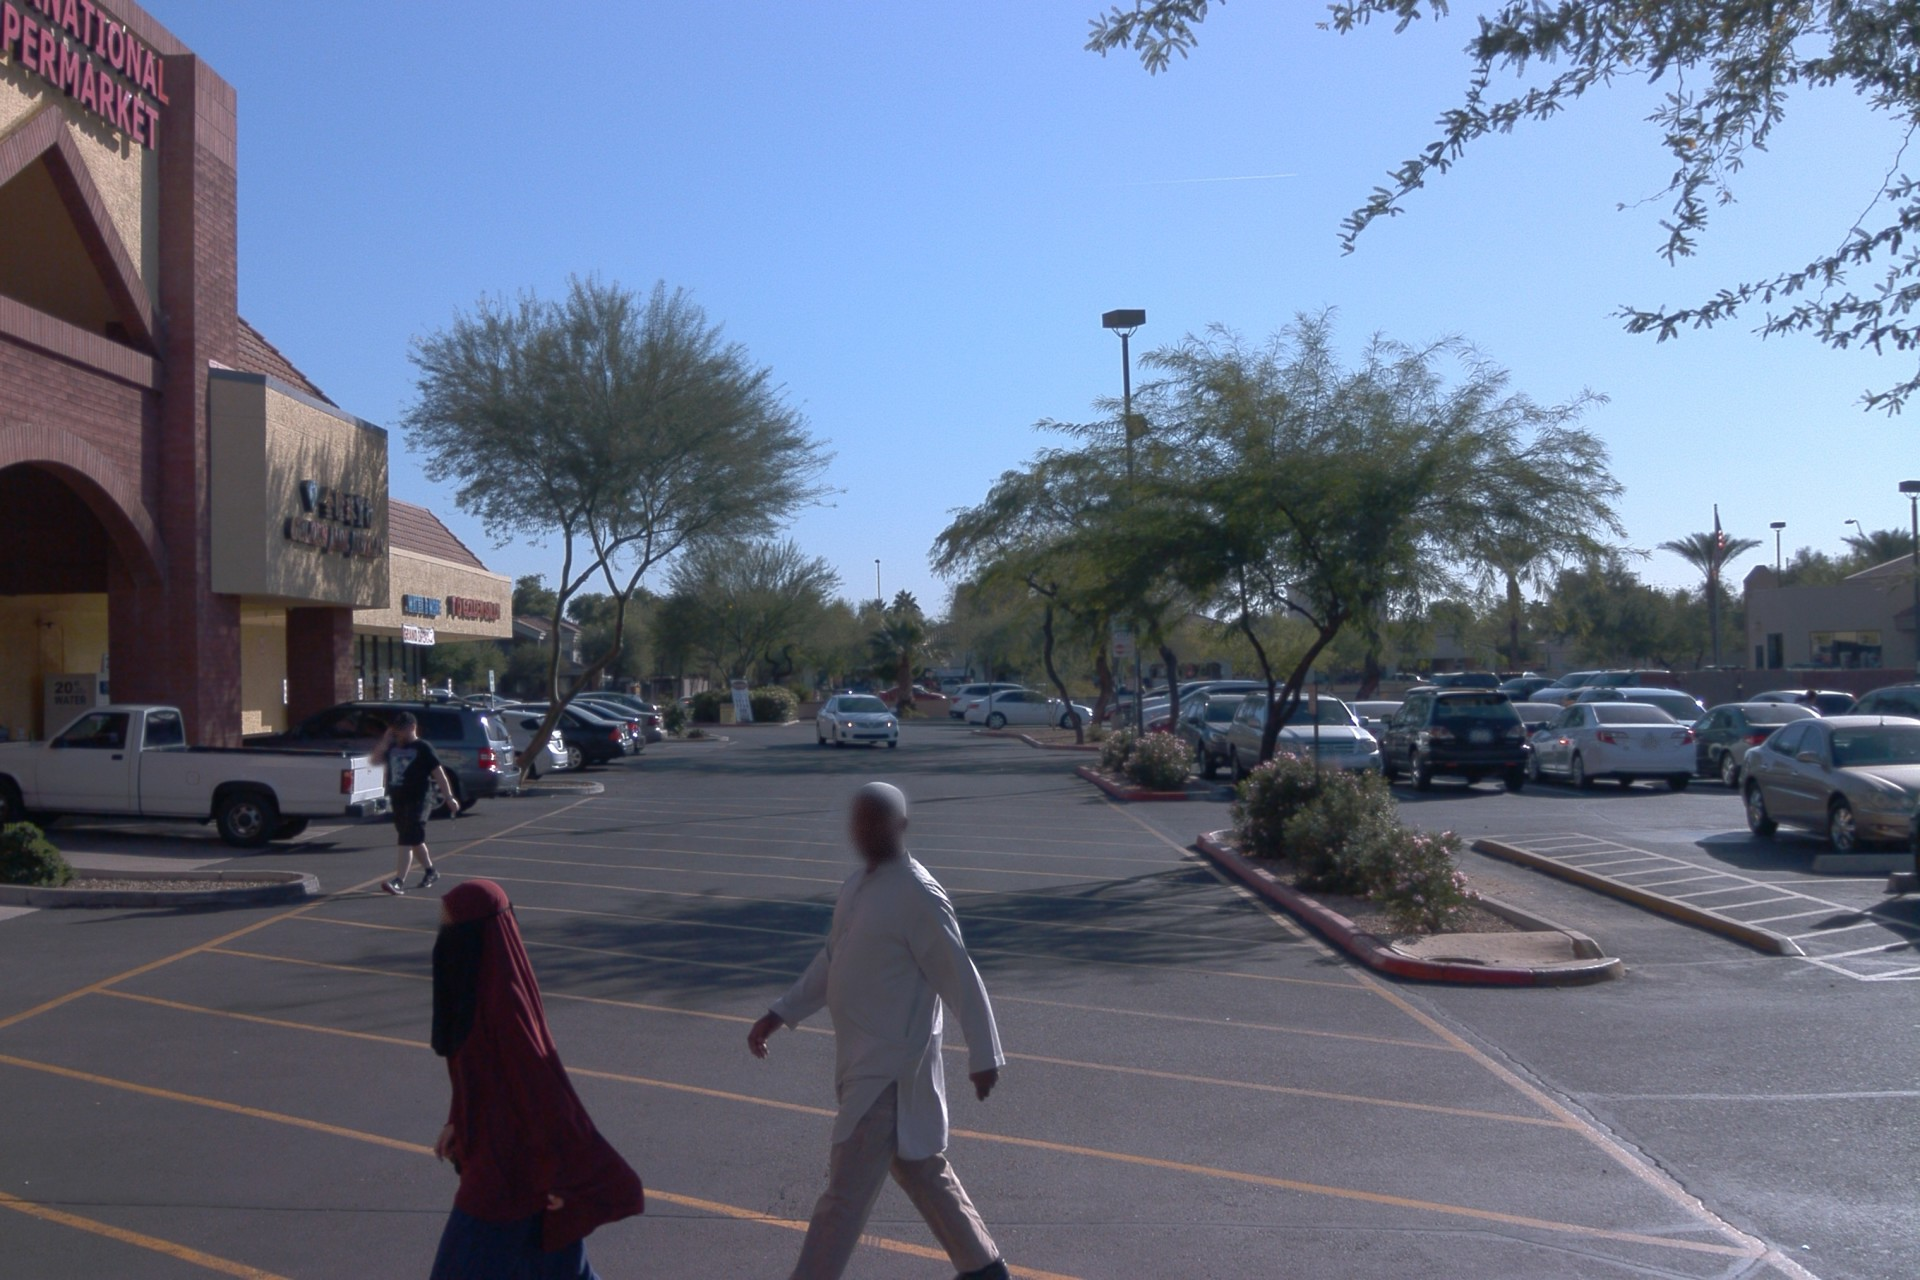

In [60]:
from PIL import Image

img = mesher.data_obj.get_image_from_frame(frame, "FRONT")
pil_image = Image.fromarray(np.uint8(img))
pil_image

# Export points in GT box

This is to assess shape completion with perfect data

In [2]:
mesher.min_lidar_pts_to_mesh = 5

for sample_idx in range(mesher.data_obj.__len__()):
    pcd_gtboxes = mesher.get_pcd_gtboxes(sample_idx)

    for object_id in range(len(pcd_gtboxes['gt_boxes'])):    

        object_pcd = pcd_gtboxes['pcd'].crop(pcd_gtboxes['gt_boxes'][object_id])

        if len(object_pcd.points) < mesher.min_lidar_pts_to_mesh:
            continue

        box_pts = np.asarray(pcd_gtboxes['gt_boxes'][object_id].get_box_points())

        if mesher.data_obj.dataset_name == 'nuscenes':
            fname = f'nsweeps-{mesher.data_obj.nsweeps}_frame-{sample_idx}_object-{object_id}_car_pts-{len(object_pcd.points)}'
        else:
            fname = f'frame-{sample_idx}_object-{object_id}_car_pts-{len(object_pcd.points)}'

        car_dir = Path(f'{mesher.data_obj.root_dir}/exported/cars')
        car_dir.mkdir(parents=True, exist_ok=True)
        o3d.io.write_point_cloud(str(car_dir / f'{fname}.pcd'), object_pcd)

        box_dir = Path(f'{mesher.data_obj.root_dir}/exported/bboxes')    
        box_dir.mkdir(parents=True, exist_ok=True)
        np.savetxt(str(box_dir / f'{fname}.txt'), box_pts, delimiter=' ')

        print(f"frame-{sample_idx}: Exported {object_id}/{len(pcd_gtboxes['gt_boxes'])} | car_pts-{len(object_pcd.points)}")


frame-1: Exported 0/1 | car_pts-9
frame-2: Exported 0/1 | car_pts-53


KeyboardInterrupt: 

# Export points in mask/bbox

This is to test out lidar segmentation on the points within a box

In [ ]:
from PIL import Image

camera_channel = 'image_2'

export_tag = 'bbox'
if export_tag == 'bbox':
    use_bbox = True
else:
    use_bbox = False

instance_dataset_id = 0
for sample_idx in range(mesher.data_obj.__len__()):
    
    i_clouds = mesher.data_obj.get_mask_instance_clouds(sample_idx, use_bbox=use_bbox)
    pcd_gtboxes = mesher.get_pcd_gtboxes(sample_idx, add_ground_lift=True)    
    inst_labels = mesher.data_obj.get_camera_instances(sample_idx, channel=camera_channel)
        
    for object_id, i_cloud in enumerate(i_clouds):
        mask_pcd = convert_to_o3dpcd(i_clouds[object_id])
        cropped_pcds, num_pts_in_gt_for_mask = [], []        
        
        if len(i_cloud) < 5:
            continue
            
        for i in range(len(pcd_gtboxes['gt_boxes'])):    
            cropped = mask_pcd.crop(pcd_gtboxes['gt_boxes'][i])
            num_pts_in_gt_for_mask.append(len(cropped.points))
            cropped_pcds.append(cropped)            
            
        if not num_pts_in_gt_for_mask or max(num_pts_in_gt_for_mask) == 0:
            labelled_pts = np.hstack([i_cloud[:,:3], np.zeros((len(i_cloud),1))])
            box_pts = np.zeros((8,3))
            num_points_in_gt = 0
        else:
            gtbox_idx = np.argmax(np.array(num_pts_in_gt_for_mask)) 
            
            cropped_np = np.array(cropped_pcds[gtbox_idx].points)
            obj_pts_labelled = np.hstack([cropped_np, 10*np.ones((len(cropped_np),1))])

            dist = mask_pcd.compute_point_cloud_distance(cropped_pcds[gtbox_idx])
            cropped_inds = np.where(np.asarray(dist) < 0.01)[0]
            mask_without_obj = np.asarray(mask_pcd.select_by_index(cropped_inds, invert=True).points)
            mask_pts_labelled = np.hstack([mask_without_obj, np.zeros((len(mask_without_obj),1))])

            labelled_pts = np.vstack([mask_pts_labelled, obj_pts_labelled])
            box_pts = np.asarray(pcd_gtboxes['gt_boxes'][gtbox_idx].get_box_points())
            num_points_in_gt = len(cropped_np)
               
        # Save pcl
        fname = f"{instance_dataset_id:06}"
        car_dir = Path(f'{mesher.data_obj.root_dir}/exported/lidar_seg_data_groundlift/points_in_{export_tag}/pointcloud')
        car_dir.mkdir(parents=True, exist_ok=True)
        car_fname = str(car_dir / f'{fname}.bin')
        points = np.float32(labelled_pts)
        points.tofile(car_fname)
        
        # Save points labels
        label_dir = Path(f'{mesher.data_obj.root_dir}/exported/lidar_seg_data_groundlift/points_in_{export_tag}/labels')
        label_dir.mkdir(parents=True, exist_ok=True)
        label_fname = str(label_dir / f'{fname}.label')
        labels = np.uint32(labelled_pts[:,3])
        labels.tofile(label_fname)
        
        # Save gt bboxes
        box_dir = Path(f'{mesher.data_obj.root_dir}/exported/lidar_seg_data_groundlift/points_in_{export_tag}/gt_bboxes')    
        box_dir.mkdir(parents=True, exist_ok=True)
        np.savetxt(str(box_dir / f'{fname}.txt'), box_pts, delimiter=' ')
        
        # Save img
        img_dir = Path(f'{mesher.data_obj.root_dir}/exported/lidar_seg_data_groundlift/points_in_{export_tag}/image')    
        img_dir.mkdir(parents=True, exist_ok=True)
        img = mesher.data_obj.get_image(sample_idx, channel=camera_channel)
        imglabels = inst_labels[object_id]
        ann_img = draw_lidar_on_image([], img, instances=[imglabels], display=False)
        Image.fromarray(ann_img).save(str(img_dir / f'{fname}.png'))

        # Save original filepath of input pointcloud
        origpath_dir = Path(f'{mesher.data_obj.root_dir}/exported/lidar_seg_data_groundlift/points_in_{export_tag}/fpath')
        origpath_dir.mkdir(parents=True, exist_ok=True)
        with open(str(origpath_dir / f'{fname}.txt'), 'w') as f:
              f.write(f'{sample_idx:06}')
        
        print(f"car #{instance_dataset_id}: Exported {object_id+1}/{len(i_clouds)} | total pts-{len(labelled_pts)}, gt pts - {num_points_in_gt}")
        instance_dataset_id = instance_dataset_id + 1

car #0: Exported 1/1 | total pts-10, gt pts - 9
car #1: Exported 1/1 | total pts-110, gt pts - 53
car #2: Exported 1/4 | total pts-408, gt pts - 0
car #3: Exported 2/4 | total pts-952, gt pts - 618
car #4: Exported 4/4 | total pts-15, gt pts - 0
car #5: Exported 1/3 | total pts-120, gt pts - 65
car #6: Exported 2/3 | total pts-33, gt pts - 25
car #7: Exported 1/5 | total pts-666, gt pts - 282
car #8: Exported 2/5 | total pts-138, gt pts - 53
car #9: Exported 3/5 | total pts-98, gt pts - 15
car #10: Exported 4/5 | total pts-10, gt pts - 0
car #11: Exported 5/5 | total pts-16, gt pts - 0
car #12: Exported 1/3 | total pts-213, gt pts - 156
car #13: Exported 2/3 | total pts-25, gt pts - 18
car #14: Exported 3/3 | total pts-7, gt pts - 5
car #15: Exported 1/10 | total pts-2959, gt pts - 1445
car #16: Exported 2/10 | total pts-1579, gt pts - 843
car #17: Exported 3/10 | total pts-3099, gt pts - 1529
car #18: Exported 4/10 | total pts-1038, gt pts - 590
car #19: Exported 5/10 | total pts-298,

car #160: Exported 2/7 | total pts-345, gt pts - 160
car #161: Exported 3/7 | total pts-113, gt pts - 60
car #162: Exported 4/7 | total pts-102, gt pts - 26
car #163: Exported 5/7 | total pts-44, gt pts - 18
car #164: Exported 6/7 | total pts-25, gt pts - 20
car #165: Exported 7/7 | total pts-10, gt pts - 0
car #166: Exported 1/6 | total pts-3209, gt pts - 1829
car #167: Exported 2/6 | total pts-640, gt pts - 389
car #168: Exported 3/6 | total pts-128, gt pts - 102
car #169: Exported 4/6 | total pts-136, gt pts - 94
car #170: Exported 5/6 | total pts-55, gt pts - 21
car #171: Exported 6/6 | total pts-49, gt pts - 22
car #172: Exported 1/9 | total pts-1543, gt pts - 931
car #173: Exported 2/9 | total pts-527, gt pts - 202
car #174: Exported 3/9 | total pts-190, gt pts - 119
car #175: Exported 4/9 | total pts-138, gt pts - 23
car #176: Exported 5/9 | total pts-169, gt pts - 134
car #177: Exported 6/9 | total pts-153, gt pts - 88
car #178: Exported 7/9 | total pts-25, gt pts - 12
car #179

car #318: Exported 1/8 | total pts-1433, gt pts - 223
car #319: Exported 2/8 | total pts-1854, gt pts - 60
car #320: Exported 3/8 | total pts-1318, gt pts - 399
car #321: Exported 4/8 | total pts-201, gt pts - 46
car #322: Exported 5/8 | total pts-216, gt pts - 53
car #323: Exported 6/8 | total pts-77, gt pts - 30
car #324: Exported 7/8 | total pts-48, gt pts - 8
car #325: Exported 8/8 | total pts-31, gt pts - 0
car #326: Exported 1/2 | total pts-156, gt pts - 120
car #327: Exported 2/2 | total pts-14, gt pts - 2
car #328: Exported 1/7 | total pts-1646, gt pts - 645
car #329: Exported 2/7 | total pts-156, gt pts - 48
car #330: Exported 3/7 | total pts-476, gt pts - 324
car #331: Exported 4/7 | total pts-451, gt pts - 176
car #332: Exported 5/7 | total pts-357, gt pts - 182
car #333: Exported 6/7 | total pts-184, gt pts - 76
car #334: Exported 7/7 | total pts-97, gt pts - 25
car #335: Exported 1/6 | total pts-844, gt pts - 424
car #336: Exported 2/6 | total pts-77, gt pts - 53
car #337:

car #476: Exported 5/11 | total pts-647, gt pts - 282
car #477: Exported 6/11 | total pts-400, gt pts - 189
car #478: Exported 7/11 | total pts-179, gt pts - 60
car #479: Exported 8/11 | total pts-328, gt pts - 134
car #480: Exported 9/11 | total pts-179, gt pts - 88
car #481: Exported 10/11 | total pts-87, gt pts - 46
car #482: Exported 11/11 | total pts-57, gt pts - 11
car #483: Exported 1/8 | total pts-3045, gt pts - 1815
car #484: Exported 2/8 | total pts-472, gt pts - 286
car #485: Exported 3/8 | total pts-367, gt pts - 155
car #486: Exported 4/8 | total pts-219, gt pts - 131
car #487: Exported 5/8 | total pts-153, gt pts - 76
car #488: Exported 6/8 | total pts-176, gt pts - 62
car #489: Exported 7/8 | total pts-116, gt pts - 68
car #490: Exported 8/8 | total pts-68, gt pts - 29
car #491: Exported 1/11 | total pts-518, gt pts - 367
car #492: Exported 2/11 | total pts-190, gt pts - 0
car #493: Exported 3/11 | total pts-439, gt pts - 150
car #494: Exported 4/11 | total pts-188, gt p

car #634: Exported 3/4 | total pts-160, gt pts - 63
car #635: Exported 4/4 | total pts-105, gt pts - 25
car #636: Exported 1/1 | total pts-888, gt pts - 504
car #637: Exported 1/10 | total pts-2860, gt pts - 1878
car #638: Exported 2/10 | total pts-1431, gt pts - 489
car #639: Exported 3/10 | total pts-1277, gt pts - 685
car #640: Exported 4/10 | total pts-774, gt pts - 346
car #641: Exported 5/10 | total pts-580, gt pts - 146
car #642: Exported 6/10 | total pts-503, gt pts - 299
car #643: Exported 7/10 | total pts-491, gt pts - 247
car #644: Exported 8/10 | total pts-212, gt pts - 126
car #645: Exported 9/10 | total pts-51, gt pts - 28
car #646: Exported 10/10 | total pts-83, gt pts - 40
car #647: Exported 1/6 | total pts-130, gt pts - 11
car #648: Exported 2/6 | total pts-41, gt pts - 13
car #649: Exported 3/6 | total pts-40, gt pts - 28
car #650: Exported 1/3 | total pts-1348, gt pts - 262
car #651: Exported 2/3 | total pts-2139, gt pts - 1339
car #652: Exported 3/3 | total pts-191,

car #791: Exported 1/12 | total pts-3720, gt pts - 2013
car #792: Exported 2/12 | total pts-1294, gt pts - 396
car #793: Exported 3/12 | total pts-367, gt pts - 114
car #794: Exported 4/12 | total pts-671, gt pts - 341
car #795: Exported 5/12 | total pts-397, gt pts - 222
car #796: Exported 6/12 | total pts-357, gt pts - 199
car #797: Exported 7/12 | total pts-326, gt pts - 203
car #798: Exported 8/12 | total pts-604, gt pts - 237
car #799: Exported 9/12 | total pts-289, gt pts - 78
car #800: Exported 10/12 | total pts-72, gt pts - 10
car #801: Exported 11/12 | total pts-98, gt pts - 43
car #802: Exported 12/12 | total pts-17, gt pts - 15
car #803: Exported 1/2 | total pts-184, gt pts - 112
car #804: Exported 2/2 | total pts-17, gt pts - 10
car #805: Exported 1/7 | total pts-519, gt pts - 230
car #806: Exported 2/7 | total pts-540, gt pts - 335
car #807: Exported 3/7 | total pts-90, gt pts - 17
car #808: Exported 4/7 | total pts-74, gt pts - 27
car #809: Exported 5/7 | total pts-15, gt

car #948: Exported 2/5 | total pts-453, gt pts - 247
car #949: Exported 3/5 | total pts-46, gt pts - 0
car #950: Exported 4/5 | total pts-54, gt pts - 17
car #951: Exported 5/5 | total pts-42, gt pts - 7
car #952: Exported 1/2 | total pts-1810, gt pts - 672
car #953: Exported 2/2 | total pts-285, gt pts - 200
car #954: Exported 1/8 | total pts-3480, gt pts - 1862
car #955: Exported 2/8 | total pts-849, gt pts - 512
car #956: Exported 3/8 | total pts-134, gt pts - 91
car #957: Exported 4/8 | total pts-402, gt pts - 240
car #958: Exported 5/8 | total pts-167, gt pts - 102
car #959: Exported 6/8 | total pts-210, gt pts - 121
car #960: Exported 7/8 | total pts-60, gt pts - 36
car #961: Exported 8/8 | total pts-15, gt pts - 2
car #962: Exported 1/1 | total pts-47, gt pts - 47
car #963: Exported 1/1 | total pts-11, gt pts - 8
car #964: Exported 1/3 | total pts-335, gt pts - 158
car #965: Exported 2/3 | total pts-17, gt pts - 4
car #966: Exported 3/3 | total pts-8, gt pts - 0
car #967: Export

car #1104: Exported 4/11 | total pts-286, gt pts - 182
car #1105: Exported 5/11 | total pts-144, gt pts - 73
car #1106: Exported 6/11 | total pts-105, gt pts - 33
car #1107: Exported 7/11 | total pts-18, gt pts - 0
car #1108: Exported 8/11 | total pts-12, gt pts - 0
car #1109: Exported 9/11 | total pts-26, gt pts - 0
car #1110: Exported 1/6 | total pts-1073, gt pts - 320
car #1111: Exported 2/6 | total pts-68, gt pts - 15
car #1112: Exported 3/6 | total pts-28, gt pts - 11
car #1113: Exported 4/6 | total pts-31, gt pts - 0
car #1114: Exported 5/6 | total pts-7, gt pts - 1
car #1115: Exported 1/9 | total pts-1324, gt pts - 783
car #1116: Exported 2/9 | total pts-1208, gt pts - 833
car #1117: Exported 3/9 | total pts-347, gt pts - 235
car #1118: Exported 4/9 | total pts-258, gt pts - 93
car #1119: Exported 5/9 | total pts-217, gt pts - 153
car #1120: Exported 6/9 | total pts-122, gt pts - 101
car #1121: Exported 7/9 | total pts-78, gt pts - 17
car #1122: Exported 8/9 | total pts-81, gt p

car #1258: Exported 2/9 | total pts-795, gt pts - 343
car #1259: Exported 3/9 | total pts-382, gt pts - 188
car #1260: Exported 4/9 | total pts-260, gt pts - 165
car #1261: Exported 5/9 | total pts-70, gt pts - 33
car #1262: Exported 6/9 | total pts-72, gt pts - 47
car #1263: Exported 7/9 | total pts-47, gt pts - 16
car #1264: Exported 8/9 | total pts-23, gt pts - 9
car #1265: Exported 1/4 | total pts-701, gt pts - 241
car #1266: Exported 2/4 | total pts-56, gt pts - 0
car #1267: Exported 3/4 | total pts-107, gt pts - 68
car #1268: Exported 4/4 | total pts-19, gt pts - 4
car #1269: Exported 1/3 | total pts-1395, gt pts - 312
car #1270: Exported 2/3 | total pts-235, gt pts - 0
car #1271: Exported 3/3 | total pts-275, gt pts - 126
car #1272: Exported 1/6 | total pts-628, gt pts - 451
car #1273: Exported 2/6 | total pts-463, gt pts - 241
car #1274: Exported 3/6 | total pts-75, gt pts - 35
car #1275: Exported 4/6 | total pts-166, gt pts - 57
car #1276: Exported 5/6 | total pts-67, gt pts -

car #1413: Exported 4/7 | total pts-64, gt pts - 24
car #1414: Exported 5/7 | total pts-32, gt pts - 11
car #1415: Exported 6/7 | total pts-67, gt pts - 30
car #1416: Exported 7/7 | total pts-117, gt pts - 84
car #1417: Exported 1/4 | total pts-394, gt pts - 173
car #1418: Exported 2/4 | total pts-97, gt pts - 15
car #1419: Exported 3/4 | total pts-19, gt pts - 9
car #1420: Exported 4/4 | total pts-6, gt pts - 0
car #1421: Exported 1/3 | total pts-760, gt pts - 508
car #1422: Exported 2/3 | total pts-248, gt pts - 0
car #1423: Exported 3/3 | total pts-64, gt pts - 31
car #1424: Exported 1/6 | total pts-580, gt pts - 311
car #1425: Exported 2/6 | total pts-228, gt pts - 67
car #1426: Exported 3/6 | total pts-55, gt pts - 31
car #1427: Exported 4/6 | total pts-22, gt pts - 9
car #1428: Exported 5/6 | total pts-7, gt pts - 0
car #1429: Exported 6/6 | total pts-12, gt pts - 1
car #1430: Exported 1/4 | total pts-285, gt pts - 176
car #1431: Exported 2/4 | total pts-75, gt pts - 16
car #1432

car #1567: Exported 5/8 | total pts-108, gt pts - 59
car #1568: Exported 6/8 | total pts-48, gt pts - 36
car #1569: Exported 7/8 | total pts-36, gt pts - 0
car #1570: Exported 1/1 | total pts-405, gt pts - 149
car #1571: Exported 1/10 | total pts-3530, gt pts - 2072
car #1572: Exported 2/10 | total pts-801, gt pts - 388
car #1573: Exported 3/10 | total pts-469, gt pts - 276
car #1574: Exported 4/10 | total pts-219, gt pts - 94
car #1575: Exported 5/10 | total pts-39, gt pts - 19
car #1576: Exported 6/10 | total pts-123, gt pts - 34
car #1577: Exported 7/10 | total pts-95, gt pts - 34
car #1578: Exported 8/10 | total pts-55, gt pts - 14
car #1579: Exported 9/10 | total pts-11, gt pts - 0
car #1580: Exported 10/10 | total pts-61, gt pts - 19
car #1581: Exported 1/13 | total pts-2506, gt pts - 1476
car #1582: Exported 2/13 | total pts-1886, gt pts - 40
car #1583: Exported 3/13 | total pts-297, gt pts - 123
car #1584: Exported 4/13 | total pts-701, gt pts - 313
car #1585: Exported 5/13 | t

car #1721: Exported 2/5 | total pts-123, gt pts - 87
car #1722: Exported 5/5 | total pts-34, gt pts - 0
car #1723: Exported 1/3 | total pts-303, gt pts - 107
car #1724: Exported 2/3 | total pts-58, gt pts - 33
car #1725: Exported 3/3 | total pts-23, gt pts - 0
car #1726: Exported 1/6 | total pts-111, gt pts - 0
car #1727: Exported 2/6 | total pts-29, gt pts - 25
car #1728: Exported 3/6 | total pts-6, gt pts - 0
car #1729: Exported 5/6 | total pts-6, gt pts - 0
car #1730: Exported 6/6 | total pts-15, gt pts - 0
car #1731: Exported 1/14 | total pts-1618, gt pts - 934
car #1732: Exported 2/14 | total pts-542, gt pts - 285
car #1733: Exported 3/14 | total pts-906, gt pts - 605
car #1734: Exported 4/14 | total pts-752, gt pts - 419
car #1735: Exported 5/14 | total pts-195, gt pts - 96
car #1736: Exported 6/14 | total pts-213, gt pts - 119
car #1737: Exported 7/14 | total pts-93, gt pts - 64
car #1738: Exported 8/14 | total pts-36, gt pts - 32
car #1739: Exported 9/14 | total pts-62, gt pts 

car #1875: Exported 1/12 | total pts-2398, gt pts - 1075
car #1876: Exported 2/12 | total pts-1320, gt pts - 230
car #1877: Exported 3/12 | total pts-1450, gt pts - 862
car #1878: Exported 4/12 | total pts-588, gt pts - 254
car #1879: Exported 5/12 | total pts-580, gt pts - 228
car #1880: Exported 6/12 | total pts-429, gt pts - 255
car #1881: Exported 7/12 | total pts-131, gt pts - 0
car #1882: Exported 8/12 | total pts-488, gt pts - 187
car #1883: Exported 9/12 | total pts-196, gt pts - 114
car #1884: Exported 10/12 | total pts-100, gt pts - 66
car #1885: Exported 11/12 | total pts-60, gt pts - 25
car #1886: Exported 12/12 | total pts-52, gt pts - 0
car #1887: Exported 1/2 | total pts-33, gt pts - 0
car #1888: Exported 2/2 | total pts-16, gt pts - 16
car #1889: Exported 1/10 | total pts-2056, gt pts - 919
car #1890: Exported 2/10 | total pts-398, gt pts - 256
car #1891: Exported 3/10 | total pts-558, gt pts - 170
car #1892: Exported 4/10 | total pts-296, gt pts - 90
car #1893: Exporte

car #2029: Exported 3/16 | total pts-160, gt pts - 21
car #2030: Exported 4/16 | total pts-217, gt pts - 0
car #2031: Exported 5/16 | total pts-219, gt pts - 68
car #2032: Exported 6/16 | total pts-137, gt pts - 0
car #2033: Exported 7/16 | total pts-388, gt pts - 103
car #2034: Exported 8/16 | total pts-216, gt pts - 44
car #2035: Exported 9/16 | total pts-51, gt pts - 23
car #2036: Exported 10/16 | total pts-74, gt pts - 0
car #2037: Exported 11/16 | total pts-24, gt pts - 0
car #2038: Exported 12/16 | total pts-18, gt pts - 0
car #2039: Exported 14/16 | total pts-7, gt pts - 0
car #2040: Exported 15/16 | total pts-9, gt pts - 1
car #2041: Exported 16/16 | total pts-7, gt pts - 0
car #2042: Exported 1/7 | total pts-252, gt pts - 142
car #2043: Exported 2/7 | total pts-25, gt pts - 0
car #2044: Exported 3/7 | total pts-45, gt pts - 32
car #2045: Exported 4/7 | total pts-5, gt pts - 0
car #2046: Exported 5/7 | total pts-36, gt pts - 19
car #2047: Exported 6/7 | total pts-14, gt pts - 0

car #2183: Exported 1/5 | total pts-233, gt pts - 141
car #2184: Exported 2/5 | total pts-151, gt pts - 86
car #2185: Exported 3/5 | total pts-105, gt pts - 37
car #2186: Exported 4/5 | total pts-34, gt pts - 14
car #2187: Exported 5/5 | total pts-23, gt pts - 12
car #2188: Exported 1/1 | total pts-683, gt pts - 388
car #2189: Exported 1/4 | total pts-116, gt pts - 0
car #2190: Exported 2/4 | total pts-12, gt pts - 12
car #2191: Exported 3/4 | total pts-13, gt pts - 0
car #2192: Exported 4/4 | total pts-7, gt pts - 0
car #2193: Exported 1/4 | total pts-1818, gt pts - 731
car #2194: Exported 2/4 | total pts-473, gt pts - 188
car #2195: Exported 3/4 | total pts-181, gt pts - 27
car #2196: Exported 4/4 | total pts-53, gt pts - 26
car #2197: Exported 1/5 | total pts-183, gt pts - 97
car #2198: Exported 2/5 | total pts-65, gt pts - 36
car #2199: Exported 3/5 | total pts-10, gt pts - 0
car #2200: Exported 4/5 | total pts-8, gt pts - 4
car #2201: Exported 1/12 | total pts-2276, gt pts - 1349


car #2338: Exported 10/10 | total pts-54, gt pts - 0
car #2339: Exported 1/10 | total pts-3162, gt pts - 1720
car #2340: Exported 2/10 | total pts-470, gt pts - 302
car #2341: Exported 3/10 | total pts-270, gt pts - 131
car #2342: Exported 4/10 | total pts-83, gt pts - 35
car #2343: Exported 5/10 | total pts-79, gt pts - 30
car #2344: Exported 6/10 | total pts-19, gt pts - 9
car #2345: Exported 7/10 | total pts-21, gt pts - 0
car #2346: Exported 8/10 | total pts-39, gt pts - 15
car #2347: Exported 9/10 | total pts-9, gt pts - 0
car #2348: Exported 10/10 | total pts-15, gt pts - 1
car #2349: Exported 1/6 | total pts-1802, gt pts - 918
car #2350: Exported 2/6 | total pts-414, gt pts - 121
car #2351: Exported 3/6 | total pts-62, gt pts - 14
car #2352: Exported 4/6 | total pts-74, gt pts - 47
car #2353: Exported 5/6 | total pts-12, gt pts - 0
car #2354: Exported 6/6 | total pts-15, gt pts - 1
car #2355: Exported 1/8 | total pts-1555, gt pts - 315
car #2356: Exported 2/8 | total pts-1572, g

car #2492: Exported 11/12 | total pts-90, gt pts - 17
car #2493: Exported 12/12 | total pts-12, gt pts - 7
car #2494: Exported 1/12 | total pts-256, gt pts - 0
car #2495: Exported 2/12 | total pts-104, gt pts - 0
car #2496: Exported 3/12 | total pts-107, gt pts - 0
car #2497: Exported 4/12 | total pts-73, gt pts - 0
car #2498: Exported 5/12 | total pts-61, gt pts - 45
car #2499: Exported 6/12 | total pts-29, gt pts - 0
car #2500: Exported 7/12 | total pts-51, gt pts - 0
car #2501: Exported 8/12 | total pts-51, gt pts - 0
car #2502: Exported 10/12 | total pts-24, gt pts - 0
car #2503: Exported 11/12 | total pts-21, gt pts - 0
car #2504: Exported 1/9 | total pts-968, gt pts - 560
car #2505: Exported 2/9 | total pts-611, gt pts - 344
car #2506: Exported 3/9 | total pts-971, gt pts - 673
car #2507: Exported 4/9 | total pts-377, gt pts - 213
car #2508: Exported 5/9 | total pts-196, gt pts - 75
car #2509: Exported 6/9 | total pts-172, gt pts - 116
car #2510: Exported 7/9 | total pts-129, gt 

car #2648: Exported 3/16 | total pts-627, gt pts - 279
car #2649: Exported 4/16 | total pts-499, gt pts - 82
car #2650: Exported 5/16 | total pts-364, gt pts - 136
car #2651: Exported 6/16 | total pts-161, gt pts - 0
car #2652: Exported 7/16 | total pts-59, gt pts - 0
car #2653: Exported 8/16 | total pts-221, gt pts - 0
car #2654: Exported 9/16 | total pts-202, gt pts - 39
car #2655: Exported 10/16 | total pts-32, gt pts - 0
car #2656: Exported 11/16 | total pts-48, gt pts - 17
car #2657: Exported 12/16 | total pts-179, gt pts - 18
car #2658: Exported 13/16 | total pts-16, gt pts - 0
car #2659: Exported 14/16 | total pts-17, gt pts - 0
car #2660: Exported 15/16 | total pts-9, gt pts - 4
car #2661: Exported 1/3 | total pts-192, gt pts - 0
car #2662: Exported 2/3 | total pts-43, gt pts - 0
car #2663: Exported 3/3 | total pts-14, gt pts - 12
car #2664: Exported 1/5 | total pts-240, gt pts - 144
car #2665: Exported 2/5 | total pts-47, gt pts - 39
car #2666: Exported 3/5 | total pts-40, gt 

car #2802: Exported 1/2 | total pts-316, gt pts - 222
car #2803: Exported 2/2 | total pts-13, gt pts - 0
car #2804: Exported 1/3 | total pts-209, gt pts - 146
car #2805: Exported 2/3 | total pts-97, gt pts - 26
car #2806: Exported 3/3 | total pts-30, gt pts - 25
car #2807: Exported 1/9 | total pts-2494, gt pts - 1362
car #2808: Exported 2/9 | total pts-966, gt pts - 483
car #2809: Exported 3/9 | total pts-299, gt pts - 131
car #2810: Exported 4/9 | total pts-696, gt pts - 346
car #2811: Exported 5/9 | total pts-286, gt pts - 193
car #2812: Exported 6/9 | total pts-87, gt pts - 39
car #2813: Exported 7/9 | total pts-45, gt pts - 9
car #2814: Exported 8/9 | total pts-65, gt pts - 34
car #2815: Exported 9/9 | total pts-22, gt pts - 4
car #2816: Exported 1/2 | total pts-83, gt pts - 45
car #2817: Exported 1/9 | total pts-1674, gt pts - 752
car #2818: Exported 2/9 | total pts-478, gt pts - 263
car #2819: Exported 3/9 | total pts-86, gt pts - 0
car #2820: Exported 4/9 | total pts-60, gt pts 

car #2956: Exported 4/7 | total pts-68, gt pts - 34
car #2957: Exported 5/7 | total pts-41, gt pts - 0
car #2958: Exported 6/7 | total pts-43, gt pts - 16
car #2959: Exported 7/7 | total pts-12, gt pts - 1
car #2960: Exported 1/6 | total pts-2109, gt pts - 1216
car #2961: Exported 2/6 | total pts-415, gt pts - 166
car #2962: Exported 3/6 | total pts-140, gt pts - 48
car #2963: Exported 4/6 | total pts-70, gt pts - 0
car #2964: Exported 5/6 | total pts-60, gt pts - 10
car #2965: Exported 6/6 | total pts-92, gt pts - 48
car #2966: Exported 1/4 | total pts-1469, gt pts - 877
car #2967: Exported 2/4 | total pts-244, gt pts - 167
car #2968: Exported 3/4 | total pts-76, gt pts - 52
car #2969: Exported 4/4 | total pts-129, gt pts - 71
car #2970: Exported 1/6 | total pts-994, gt pts - 410
car #2971: Exported 2/6 | total pts-178, gt pts - 41
car #2972: Exported 3/6 | total pts-11, gt pts - 2
car #2973: Exported 4/6 | total pts-9, gt pts - 0
car #2974: Exported 5/6 | total pts-16, gt pts - 0
car

car #3111: Exported 3/5 | total pts-7, gt pts - 6
car #3112: Exported 5/5 | total pts-18, gt pts - 8
car #3113: Exported 1/6 | total pts-487, gt pts - 281
car #3114: Exported 2/6 | total pts-98, gt pts - 56
car #3115: Exported 3/6 | total pts-101, gt pts - 39
car #3116: Exported 4/6 | total pts-35, gt pts - 32
car #3117: Exported 5/6 | total pts-17, gt pts - 6
car #3118: Exported 6/6 | total pts-38, gt pts - 27
car #3119: Exported 1/4 | total pts-1032, gt pts - 337
car #3120: Exported 2/4 | total pts-1041, gt pts - 7
car #3121: Exported 3/4 | total pts-83, gt pts - 43
car #3122: Exported 4/4 | total pts-33, gt pts - 0
car #3123: Exported 1/7 | total pts-1018, gt pts - 530
car #3124: Exported 2/7 | total pts-551, gt pts - 248
car #3125: Exported 3/7 | total pts-221, gt pts - 132
car #3126: Exported 4/7 | total pts-143, gt pts - 58
car #3127: Exported 5/7 | total pts-71, gt pts - 26
car #3128: Exported 6/7 | total pts-22, gt pts - 6
car #3129: Exported 7/7 | total pts-15, gt pts - 0
car 

car #3266: Exported 9/13 | total pts-39, gt pts - 0
car #3267: Exported 10/13 | total pts-14, gt pts - 0
car #3268: Exported 11/13 | total pts-12, gt pts - 0
car #3269: Exported 12/13 | total pts-23, gt pts - 14
car #3270: Exported 13/13 | total pts-12, gt pts - 0
car #3271: Exported 1/12 | total pts-2474, gt pts - 1366
car #3272: Exported 2/12 | total pts-2143, gt pts - 1277
car #3273: Exported 3/12 | total pts-1124, gt pts - 542
car #3274: Exported 4/12 | total pts-780, gt pts - 490
car #3275: Exported 5/12 | total pts-386, gt pts - 61
car #3276: Exported 6/12 | total pts-185, gt pts - 59
car #3277: Exported 7/12 | total pts-127, gt pts - 70
car #3278: Exported 8/12 | total pts-99, gt pts - 0
car #3279: Exported 9/12 | total pts-90, gt pts - 44
car #3280: Exported 10/12 | total pts-37, gt pts - 0
car #3281: Exported 11/12 | total pts-7, gt pts - 0
car #3282: Exported 12/12 | total pts-14, gt pts - 0
car #3283: Exported 1/7 | total pts-870, gt pts - 525
car #3284: Exported 2/7 | total

car #3420: Exported 2/3 | total pts-656, gt pts - 489
car #3421: Exported 3/3 | total pts-12, gt pts - 0
car #3422: Exported 1/1 | total pts-41, gt pts - 21
car #3423: Exported 1/9 | total pts-1841, gt pts - 974
car #3424: Exported 2/9 | total pts-551, gt pts - 436
car #3425: Exported 3/9 | total pts-736, gt pts - 333
car #3426: Exported 4/9 | total pts-501, gt pts - 270
car #3427: Exported 5/9 | total pts-291, gt pts - 130
car #3428: Exported 6/9 | total pts-209, gt pts - 67
car #3429: Exported 7/9 | total pts-433, gt pts - 166
car #3430: Exported 8/9 | total pts-200, gt pts - 89
car #3431: Exported 9/9 | total pts-46, gt pts - 10
car #3432: Exported 1/7 | total pts-32, gt pts - 0
car #3433: Exported 2/7 | total pts-11, gt pts - 0
car #3434: Exported 3/7 | total pts-9, gt pts - 0
car #3435: Exported 5/7 | total pts-6, gt pts - 0
car #3436: Exported 6/7 | total pts-6, gt pts - 0
car #3437: Exported 1/2 | total pts-172, gt pts - 129
car #3438: Exported 2/2 | total pts-9, gt pts - 8
car 

car #3576: Exported 6/12 | total pts-345, gt pts - 210
car #3577: Exported 7/12 | total pts-312, gt pts - 238
car #3578: Exported 8/12 | total pts-65, gt pts - 46
car #3579: Exported 9/12 | total pts-72, gt pts - 35
car #3580: Exported 10/12 | total pts-9, gt pts - 0
car #3581: Exported 11/12 | total pts-15, gt pts - 0
car #3582: Exported 12/12 | total pts-21, gt pts - 1
car #3583: Exported 1/9 | total pts-1634, gt pts - 318
car #3584: Exported 2/9 | total pts-673, gt pts - 357
car #3585: Exported 3/9 | total pts-409, gt pts - 244
car #3586: Exported 4/9 | total pts-228, gt pts - 159
car #3587: Exported 5/9 | total pts-236, gt pts - 147
car #3588: Exported 6/9 | total pts-75, gt pts - 34
car #3589: Exported 7/9 | total pts-95, gt pts - 44
car #3590: Exported 8/9 | total pts-57, gt pts - 39
car #3591: Exported 9/9 | total pts-32, gt pts - 29
car #3592: Exported 1/9 | total pts-1767, gt pts - 611
car #3593: Exported 2/9 | total pts-133, gt pts - 45
car #3594: Exported 3/9 | total pts-73,

car #3731: Exported 9/9 | total pts-34, gt pts - 25
car #3732: Exported 1/3 | total pts-491, gt pts - 271
car #3733: Exported 2/3 | total pts-118, gt pts - 0
car #3734: Exported 3/3 | total pts-39, gt pts - 0
car #3735: Exported 1/8 | total pts-1022, gt pts - 546
car #3736: Exported 2/8 | total pts-1276, gt pts - 741
car #3737: Exported 3/8 | total pts-533, gt pts - 258
car #3738: Exported 4/8 | total pts-862, gt pts - 471
car #3739: Exported 5/8 | total pts-84, gt pts - 0
car #3740: Exported 6/8 | total pts-28, gt pts - 15
car #3741: Exported 7/8 | total pts-9, gt pts - 0
car #3742: Exported 8/8 | total pts-11, gt pts - 0
car #3743: Exported 1/4 | total pts-1837, gt pts - 778
car #3744: Exported 2/4 | total pts-77, gt pts - 17
car #3745: Exported 3/4 | total pts-5, gt pts - 0
car #3746: Exported 4/4 | total pts-22, gt pts - 0
car #3747: Exported 1/13 | total pts-2298, gt pts - 1171
car #3748: Exported 2/13 | total pts-886, gt pts - 212
car #3749: Exported 3/13 | total pts-744, gt pts 

car #3885: Exported 3/7 | total pts-36, gt pts - 0
car #3886: Exported 4/7 | total pts-11, gt pts - 0
car #3887: Exported 5/7 | total pts-19, gt pts - 0
car #3888: Exported 1/1 | total pts-141, gt pts - 23
car #3889: Exported 1/4 | total pts-25, gt pts - 20
car #3890: Exported 2/4 | total pts-14, gt pts - 12
car #3891: Exported 3/4 | total pts-9, gt pts - 0
car #3892: Exported 4/4 | total pts-7, gt pts - 0
car #3893: Exported 1/10 | total pts-487, gt pts - 209
car #3894: Exported 2/10 | total pts-942, gt pts - 423
car #3895: Exported 3/10 | total pts-706, gt pts - 367
car #3896: Exported 4/10 | total pts-224, gt pts - 123
car #3897: Exported 5/10 | total pts-303, gt pts - 142
car #3898: Exported 6/10 | total pts-153, gt pts - 121
car #3899: Exported 7/10 | total pts-151, gt pts - 62
car #3900: Exported 8/10 | total pts-12, gt pts - 3
car #3901: Exported 9/10 | total pts-29, gt pts - 9
car #3902: Exported 1/2 | total pts-258, gt pts - 200
car #3903: Exported 2/2 | total pts-5, gt pts - 

car #4039: Exported 3/3 | total pts-68, gt pts - 22
car #4040: Exported 1/9 | total pts-3080, gt pts - 1514
car #4041: Exported 2/9 | total pts-396, gt pts - 176
car #4042: Exported 3/9 | total pts-354, gt pts - 1
car #4043: Exported 4/9 | total pts-267, gt pts - 0
car #4044: Exported 5/9 | total pts-48, gt pts - 23
car #4045: Exported 6/9 | total pts-53, gt pts - 13
car #4046: Exported 7/9 | total pts-16, gt pts - 0
car #4047: Exported 8/9 | total pts-22, gt pts - 0
car #4048: Exported 9/9 | total pts-19, gt pts - 0
car #4049: Exported 1/5 | total pts-1171, gt pts - 0
car #4050: Exported 2/5 | total pts-172, gt pts - 108
car #4051: Exported 3/5 | total pts-143, gt pts - 116
car #4052: Exported 4/5 | total pts-28, gt pts - 13
car #4053: Exported 5/5 | total pts-6, gt pts - 3
car #4054: Exported 1/7 | total pts-130, gt pts - 80
car #4055: Exported 2/7 | total pts-44, gt pts - 35
car #4056: Exported 3/7 | total pts-33, gt pts - 0
car #4057: Exported 4/7 | total pts-35, gt pts - 2
car #40

car #4195: Exported 3/5 | total pts-787, gt pts - 453
car #4196: Exported 4/5 | total pts-1012, gt pts - 619
car #4197: Exported 5/5 | total pts-276, gt pts - 176
car #4198: Exported 1/6 | total pts-2321, gt pts - 0
car #4199: Exported 2/6 | total pts-907, gt pts - 13
car #4200: Exported 3/6 | total pts-658, gt pts - 369
car #4201: Exported 4/6 | total pts-130, gt pts - 58
car #4202: Exported 5/6 | total pts-77, gt pts - 32
car #4203: Exported 6/6 | total pts-6, gt pts - 0
car #4204: Exported 1/7 | total pts-923, gt pts - 515
car #4205: Exported 2/7 | total pts-837, gt pts - 516
car #4206: Exported 3/7 | total pts-124, gt pts - 43
car #4207: Exported 4/7 | total pts-215, gt pts - 95
car #4208: Exported 5/7 | total pts-106, gt pts - 84
car #4209: Exported 6/7 | total pts-34, gt pts - 9
car #4210: Exported 7/7 | total pts-16, gt pts - 8
car #4211: Exported 1/4 | total pts-160, gt pts - 114
car #4212: Exported 2/4 | total pts-40, gt pts - 16
car #4213: Exported 3/4 | total pts-39, gt pts 

car #4351: Exported 7/8 | total pts-10, gt pts - 6
car #4352: Exported 1/9 | total pts-1662, gt pts - 887
car #4353: Exported 2/9 | total pts-418, gt pts - 242
car #4354: Exported 3/9 | total pts-227, gt pts - 131
car #4355: Exported 4/9 | total pts-77, gt pts - 41
car #4356: Exported 5/9 | total pts-37, gt pts - 13
car #4357: Exported 6/9 | total pts-34, gt pts - 2
car #4358: Exported 7/9 | total pts-6, gt pts - 0
car #4359: Exported 8/9 | total pts-31, gt pts - 17
car #4360: Exported 9/9 | total pts-6, gt pts - 0
car #4361: Exported 1/3 | total pts-307, gt pts - 192
car #4362: Exported 2/3 | total pts-31, gt pts - 15
car #4363: Exported 3/3 | total pts-5, gt pts - 2
car #4364: Exported 1/9 | total pts-1195, gt pts - 811
car #4365: Exported 2/9 | total pts-2634, gt pts - 1607
car #4366: Exported 3/9 | total pts-1966, gt pts - 854
car #4367: Exported 4/9 | total pts-1833, gt pts - 1122
car #4368: Exported 5/9 | total pts-517, gt pts - 314
car #4369: Exported 6/9 | total pts-95, gt pts 

car #4507: Exported 3/5 | total pts-47, gt pts - 0
car #4508: Exported 4/5 | total pts-29, gt pts - 19
car #4509: Exported 1/6 | total pts-2654, gt pts - 1561
car #4510: Exported 2/6 | total pts-587, gt pts - 417
car #4511: Exported 3/6 | total pts-401, gt pts - 218
car #4512: Exported 4/6 | total pts-326, gt pts - 203
car #4513: Exported 5/6 | total pts-152, gt pts - 55
car #4514: Exported 1/5 | total pts-969, gt pts - 351
car #4515: Exported 2/5 | total pts-171, gt pts - 84
car #4516: Exported 3/5 | total pts-114, gt pts - 42
car #4517: Exported 4/5 | total pts-19, gt pts - 7
car #4518: Exported 1/10 | total pts-2665, gt pts - 1315
car #4519: Exported 2/10 | total pts-914, gt pts - 506
car #4520: Exported 3/10 | total pts-412, gt pts - 195
car #4521: Exported 4/10 | total pts-73, gt pts - 56
car #4522: Exported 5/10 | total pts-82, gt pts - 28
car #4523: Exported 6/10 | total pts-65, gt pts - 25
car #4524: Exported 7/10 | total pts-100, gt pts - 23
car #4525: Exported 8/10 | total pt

car #4661: Exported 5/9 | total pts-204, gt pts - 0
car #4662: Exported 6/9 | total pts-278, gt pts - 66
car #4663: Exported 7/9 | total pts-130, gt pts - 4
car #4664: Exported 8/9 | total pts-61, gt pts - 0
car #4665: Exported 9/9 | total pts-122, gt pts - 44
car #4666: Exported 1/4 | total pts-148, gt pts - 96
car #4667: Exported 2/4 | total pts-170, gt pts - 87
car #4668: Exported 3/4 | total pts-30, gt pts - 4
car #4669: Exported 4/4 | total pts-6, gt pts - 5
car #4670: Exported 1/1 | total pts-297, gt pts - 198
car #4671: Exported 1/3 | total pts-1237, gt pts - 701
car #4672: Exported 2/3 | total pts-64, gt pts - 23
car #4673: Exported 3/3 | total pts-87, gt pts - 31
car #4674: Exported 1/5 | total pts-432, gt pts - 202
car #4675: Exported 2/5 | total pts-137, gt pts - 101
car #4676: Exported 3/5 | total pts-127, gt pts - 77
car #4677: Exported 4/5 | total pts-30, gt pts - 10
car #4678: Exported 1/9 | total pts-814, gt pts - 499
car #4679: Exported 2/9 | total pts-444, gt pts - 25

car #4815: Exported 2/6 | total pts-676, gt pts - 380
car #4816: Exported 3/6 | total pts-204, gt pts - 62
car #4817: Exported 4/6 | total pts-121, gt pts - 92
car #4818: Exported 5/6 | total pts-9, gt pts - 1
car #4819: Exported 6/6 | total pts-16, gt pts - 2
car #4820: Exported 1/6 | total pts-435, gt pts - 308
car #4821: Exported 2/6 | total pts-163, gt pts - 63
car #4822: Exported 3/6 | total pts-162, gt pts - 92
car #4823: Exported 4/6 | total pts-133, gt pts - 9
car #4824: Exported 5/6 | total pts-48, gt pts - 8
car #4825: Exported 6/6 | total pts-20, gt pts - 2
car #4826: Exported 1/4 | total pts-1825, gt pts - 730
car #4827: Exported 2/4 | total pts-547, gt pts - 199
car #4828: Exported 3/4 | total pts-52, gt pts - 16
car #4829: Exported 4/4 | total pts-20, gt pts - 10
car #4830: Exported 1/4 | total pts-324, gt pts - 241
car #4831: Exported 2/4 | total pts-143, gt pts - 77
car #4832: Exported 3/4 | total pts-74, gt pts - 57
car #4833: Exported 1/7 | total pts-115, gt pts - 50


car #4970: Exported 1/8 | total pts-2288, gt pts - 1394
car #4971: Exported 2/8 | total pts-1001, gt pts - 617
car #4972: Exported 3/8 | total pts-230, gt pts - 146
car #4973: Exported 4/8 | total pts-110, gt pts - 41
car #4974: Exported 5/8 | total pts-128, gt pts - 22
car #4975: Exported 6/8 | total pts-47, gt pts - 13
car #4976: Exported 7/8 | total pts-44, gt pts - 0
car #4977: Exported 8/8 | total pts-87, gt pts - 49
car #4978: Exported 1/2 | total pts-5, gt pts - 5
car #4979: Exported 2/2 | total pts-17, gt pts - 0
car #4980: Exported 1/9 | total pts-1091, gt pts - 692
car #4981: Exported 2/9 | total pts-888, gt pts - 546
car #4982: Exported 3/9 | total pts-181, gt pts - 59
car #4983: Exported 4/9 | total pts-641, gt pts - 408
car #4984: Exported 5/9 | total pts-246, gt pts - 118
car #4985: Exported 6/9 | total pts-237, gt pts - 160
car #4986: Exported 7/9 | total pts-68, gt pts - 40
car #4987: Exported 8/9 | total pts-19, gt pts - 13
car #4988: Exported 9/9 | total pts-11, gt pt

car #5124: Exported 1/12 | total pts-3095, gt pts - 1514
car #5125: Exported 2/12 | total pts-2127, gt pts - 803
car #5126: Exported 3/12 | total pts-616, gt pts - 276
car #5127: Exported 4/12 | total pts-197, gt pts - 4
car #5128: Exported 5/12 | total pts-119, gt pts - 39
car #5129: Exported 6/12 | total pts-63, gt pts - 8
car #5130: Exported 7/12 | total pts-91, gt pts - 33
car #5131: Exported 8/12 | total pts-38, gt pts - 17
car #5132: Exported 9/12 | total pts-40, gt pts - 0
car #5133: Exported 10/12 | total pts-23, gt pts - 14
car #5134: Exported 12/12 | total pts-7, gt pts - 1
car #5135: Exported 1/7 | total pts-1635, gt pts - 683
car #5136: Exported 2/7 | total pts-1377, gt pts - 6
car #5137: Exported 3/7 | total pts-1276, gt pts - 0
car #5138: Exported 4/7 | total pts-196, gt pts - 129
car #5139: Exported 5/7 | total pts-151, gt pts - 72
car #5140: Exported 6/7 | total pts-70, gt pts - 27
car #5141: Exported 7/7 | total pts-59, gt pts - 27
car #5142: Exported 1/6 | total pts-2

car #5279: Exported 1/8 | total pts-2147, gt pts - 1036
car #5280: Exported 2/8 | total pts-477, gt pts - 219
car #5281: Exported 3/8 | total pts-429, gt pts - 259
car #5282: Exported 4/8 | total pts-62, gt pts - 38
car #5283: Exported 5/8 | total pts-59, gt pts - 40
car #5284: Exported 6/8 | total pts-81, gt pts - 36
car #5285: Exported 7/8 | total pts-11, gt pts - 4
car #5286: Exported 8/8 | total pts-23, gt pts - 8
car #5287: Exported 1/4 | total pts-1703, gt pts - 1019
car #5288: Exported 2/4 | total pts-203, gt pts - 123
car #5289: Exported 3/4 | total pts-103, gt pts - 27
car #5290: Exported 4/4 | total pts-28, gt pts - 21
car #5291: Exported 1/12 | total pts-186, gt pts - 80
car #5292: Exported 2/12 | total pts-56, gt pts - 22
car #5293: Exported 3/12 | total pts-66, gt pts - 41
car #5294: Exported 4/12 | total pts-12, gt pts - 5
car #5295: Exported 5/12 | total pts-6, gt pts - 0
car #5296: Exported 6/12 | total pts-38, gt pts - 8
car #5297: Exported 7/12 | total pts-11, gt pts 

car #5433: Exported 4/4 | total pts-14, gt pts - 13
car #5434: Exported 1/5 | total pts-2765, gt pts - 1189
car #5435: Exported 2/5 | total pts-436, gt pts - 249
car #5436: Exported 3/5 | total pts-158, gt pts - 116
car #5437: Exported 4/5 | total pts-33, gt pts - 20
car #5438: Exported 5/5 | total pts-12, gt pts - 11
car #5439: Exported 1/8 | total pts-1320, gt pts - 597
car #5440: Exported 2/8 | total pts-1245, gt pts - 750
car #5441: Exported 3/8 | total pts-306, gt pts - 87
car #5442: Exported 4/8 | total pts-217, gt pts - 88
car #5443: Exported 5/8 | total pts-68, gt pts - 31
car #5444: Exported 6/8 | total pts-131, gt pts - 0
car #5445: Exported 7/8 | total pts-10, gt pts - 0
car #5446: Exported 1/4 | total pts-12, gt pts - 1
car #5447: Exported 2/4 | total pts-19, gt pts - 4
car #5448: Exported 3/4 | total pts-23, gt pts - 17
car #5449: Exported 4/4 | total pts-11, gt pts - 0
car #5450: Exported 1/8 | total pts-88, gt pts - 0
car #5451: Exported 2/8 | total pts-75, gt pts - 0
ca

car #5588: Exported 6/7 | total pts-26, gt pts - 1
car #5589: Exported 7/7 | total pts-31, gt pts - 11
car #5590: Exported 1/4 | total pts-2561, gt pts - 616
car #5591: Exported 2/4 | total pts-687, gt pts - 414
car #5592: Exported 3/4 | total pts-109, gt pts - 63
car #5593: Exported 4/4 | total pts-47, gt pts - 14
car #5594: Exported 1/7 | total pts-1887, gt pts - 399
car #5595: Exported 2/7 | total pts-1747, gt pts - 1154
car #5596: Exported 3/7 | total pts-1045, gt pts - 608
car #5597: Exported 4/7 | total pts-963, gt pts - 297
car #5598: Exported 5/7 | total pts-212, gt pts - 124
car #5599: Exported 6/7 | total pts-231, gt pts - 113
car #5600: Exported 7/7 | total pts-89, gt pts - 16
car #5601: Exported 1/6 | total pts-134, gt pts - 35
car #5602: Exported 3/6 | total pts-9, gt pts - 7
car #5603: Exported 5/6 | total pts-5, gt pts - 2
car #5604: Exported 6/6 | total pts-15, gt pts - 0
car #5605: Exported 1/6 | total pts-1034, gt pts - 0
car #5606: Exported 2/6 | total pts-557, gt pt

car #5743: Exported 3/9 | total pts-219, gt pts - 156
car #5744: Exported 4/9 | total pts-90, gt pts - 0
car #5745: Exported 5/9 | total pts-41, gt pts - 0
car #5746: Exported 6/9 | total pts-47, gt pts - 19
car #5747: Exported 7/9 | total pts-7, gt pts - 0
car #5748: Exported 8/9 | total pts-9, gt pts - 0
car #5749: Exported 1/4 | total pts-200, gt pts - 78
car #5750: Exported 2/4 | total pts-39, gt pts - 26
car #5751: Exported 3/4 | total pts-5, gt pts - 0
car #5752: Exported 4/4 | total pts-7, gt pts - 0
car #5753: Exported 1/2 | total pts-79, gt pts - 50
car #5754: Exported 2/2 | total pts-6, gt pts - 6
car #5755: Exported 1/11 | total pts-2541, gt pts - 1209
car #5756: Exported 2/11 | total pts-1557, gt pts - 358
car #5757: Exported 3/11 | total pts-340, gt pts - 107
car #5758: Exported 4/11 | total pts-872, gt pts - 262
car #5759: Exported 5/11 | total pts-287, gt pts - 189
car #5760: Exported 6/11 | total pts-101, gt pts - 53
car #5761: Exported 7/11 | total pts-80, gt pts - 45


car #5896: Exported 3/6 | total pts-102, gt pts - 93
car #5897: Exported 4/6 | total pts-56, gt pts - 14
car #5898: Exported 5/6 | total pts-26, gt pts - 3
car #5899: Exported 6/6 | total pts-10, gt pts - 0
car #5900: Exported 1/9 | total pts-1495, gt pts - 340
car #5901: Exported 2/9 | total pts-579, gt pts - 337
car #5902: Exported 3/9 | total pts-576, gt pts - 415
car #5903: Exported 4/9 | total pts-431, gt pts - 286
car #5904: Exported 5/9 | total pts-296, gt pts - 133
car #5905: Exported 6/9 | total pts-149, gt pts - 57
car #5906: Exported 7/9 | total pts-142, gt pts - 95
car #5907: Exported 8/9 | total pts-133, gt pts - 101
car #5908: Exported 9/9 | total pts-44, gt pts - 0
car #5909: Exported 1/3 | total pts-70, gt pts - 23
car #5910: Exported 2/3 | total pts-7, gt pts - 5
car #5911: Exported 3/3 | total pts-5, gt pts - 1
car #5912: Exported 1/11 | total pts-2077, gt pts - 854
car #5913: Exported 2/11 | total pts-1454, gt pts - 774
car #5914: Exported 3/11 | total pts-813, gt pt

car #6051: Exported 3/4 | total pts-21, gt pts - 17
car #6052: Exported 4/4 | total pts-24, gt pts - 15
car #6053: Exported 1/6 | total pts-615, gt pts - 284
car #6054: Exported 2/6 | total pts-509, gt pts - 295
car #6055: Exported 3/6 | total pts-260, gt pts - 164
car #6056: Exported 4/6 | total pts-21, gt pts - 13
car #6057: Exported 5/6 | total pts-28, gt pts - 2
car #6058: Exported 6/6 | total pts-6, gt pts - 6
car #6059: Exported 1/12 | total pts-1930, gt pts - 780
car #6060: Exported 2/12 | total pts-1226, gt pts - 763
car #6061: Exported 3/12 | total pts-591, gt pts - 357
car #6062: Exported 4/12 | total pts-474, gt pts - 261
car #6063: Exported 5/12 | total pts-238, gt pts - 121
car #6064: Exported 6/12 | total pts-70, gt pts - 32
car #6065: Exported 7/12 | total pts-28, gt pts - 21
car #6066: Exported 8/12 | total pts-80, gt pts - 18
car #6067: Exported 9/12 | total pts-14, gt pts - 0
car #6068: Exported 10/12 | total pts-9, gt pts - 3
car #6069: Exported 11/12 | total pts-13,

car #6206: Exported 2/4 | total pts-273, gt pts - 148
car #6207: Exported 3/4 | total pts-294, gt pts - 0
car #6208: Exported 4/4 | total pts-43, gt pts - 21
car #6209: Exported 1/5 | total pts-1449, gt pts - 483
car #6210: Exported 2/5 | total pts-214, gt pts - 95
car #6211: Exported 3/5 | total pts-67, gt pts - 39
car #6212: Exported 4/5 | total pts-70, gt pts - 44
car #6213: Exported 5/5 | total pts-39, gt pts - 8
car #6214: Exported 1/5 | total pts-1436, gt pts - 794
car #6215: Exported 2/5 | total pts-99, gt pts - 0
car #6216: Exported 3/5 | total pts-108, gt pts - 0
car #6217: Exported 4/5 | total pts-15, gt pts - 9
car #6218: Exported 5/5 | total pts-6, gt pts - 0
car #6219: Exported 1/13 | total pts-2463, gt pts - 1508
car #6220: Exported 2/13 | total pts-2252, gt pts - 1219
car #6221: Exported 3/13 | total pts-2021, gt pts - 801
car #6222: Exported 4/13 | total pts-558, gt pts - 337
car #6223: Exported 5/13 | total pts-79, gt pts - 0
car #6224: Exported 6/13 | total pts-110, g

car #6362: Exported 1/5 | total pts-154, gt pts - 111
car #6363: Exported 2/5 | total pts-76, gt pts - 40
car #6364: Exported 3/5 | total pts-38, gt pts - 8
car #6365: Exported 4/5 | total pts-28, gt pts - 3
car #6366: Exported 1/2 | total pts-658, gt pts - 298
car #6367: Exported 2/2 | total pts-17, gt pts - 11
car #6368: Exported 1/1 | total pts-8, gt pts - 3
car #6369: Exported 1/1 | total pts-50, gt pts - 30
car #6370: Exported 1/4 | total pts-13, gt pts - 7
car #6371: Exported 2/4 | total pts-11, gt pts - 0
car #6372: Exported 3/4 | total pts-10, gt pts - 5
car #6373: Exported 4/4 | total pts-25, gt pts - 18
car #6374: Exported 1/4 | total pts-69, gt pts - 0
car #6375: Exported 2/4 | total pts-53, gt pts - 0
car #6376: Exported 3/4 | total pts-15, gt pts - 0
car #6377: Exported 4/4 | total pts-26, gt pts - 0
car #6378: Exported 1/2 | total pts-2236, gt pts - 1264
car #6379: Exported 2/2 | total pts-224, gt pts - 86
car #6380: Exported 1/2 | total pts-1333, gt pts - 248
car #6381: 

car #6517: Exported 2/11 | total pts-1294, gt pts - 691
car #6518: Exported 3/11 | total pts-729, gt pts - 263
car #6519: Exported 4/11 | total pts-986, gt pts - 392
car #6520: Exported 5/11 | total pts-749, gt pts - 522
car #6521: Exported 6/11 | total pts-404, gt pts - 160
car #6522: Exported 7/11 | total pts-100, gt pts - 30
car #6523: Exported 8/11 | total pts-71, gt pts - 19
car #6524: Exported 9/11 | total pts-35, gt pts - 6
car #6525: Exported 10/11 | total pts-14, gt pts - 0
car #6526: Exported 11/11 | total pts-7, gt pts - 0
car #6527: Exported 1/10 | total pts-832, gt pts - 608
car #6528: Exported 2/10 | total pts-1005, gt pts - 560
car #6529: Exported 3/10 | total pts-675, gt pts - 246
car #6530: Exported 4/10 | total pts-479, gt pts - 228
car #6531: Exported 5/10 | total pts-244, gt pts - 98
car #6532: Exported 6/10 | total pts-225, gt pts - 127
car #6533: Exported 7/10 | total pts-138, gt pts - 75
car #6534: Exported 8/10 | total pts-84, gt pts - 40
car #6535: Exported 9/1

car #6670: Exported 2/9 | total pts-107, gt pts - 37
car #6671: Exported 3/9 | total pts-15, gt pts - 0
car #6672: Exported 4/9 | total pts-53, gt pts - 0
car #6673: Exported 5/9 | total pts-19, gt pts - 0
car #6674: Exported 6/9 | total pts-24, gt pts - 24
car #6675: Exported 7/9 | total pts-6, gt pts - 3
car #6676: Exported 8/9 | total pts-5, gt pts - 0
car #6677: Exported 1/2 | total pts-211, gt pts - 126
car #6678: Exported 2/2 | total pts-37, gt pts - 0
car #6679: Exported 1/3 | total pts-6, gt pts - 6
car #6680: Exported 2/3 | total pts-11, gt pts - 10
car #6681: Exported 3/3 | total pts-22, gt pts - 0
car #6682: Exported 1/7 | total pts-222, gt pts - 0
car #6683: Exported 2/7 | total pts-231, gt pts - 148
car #6684: Exported 3/7 | total pts-140, gt pts - 42
car #6685: Exported 4/7 | total pts-75, gt pts - 55
car #6686: Exported 5/7 | total pts-50, gt pts - 14
car #6687: Exported 6/7 | total pts-19, gt pts - 0
car #6688: Exported 1/4 | total pts-1332, gt pts - 748
car #6689: Expo

car #6827: Exported 4/12 | total pts-195, gt pts - 37
car #6828: Exported 5/12 | total pts-399, gt pts - 156
car #6829: Exported 6/12 | total pts-60, gt pts - 24
car #6830: Exported 7/12 | total pts-24, gt pts - 13
car #6831: Exported 8/12 | total pts-47, gt pts - 4
car #6832: Exported 9/12 | total pts-9, gt pts - 3
car #6833: Exported 10/12 | total pts-38, gt pts - 0
car #6834: Exported 11/12 | total pts-37, gt pts - 4
car #6835: Exported 12/12 | total pts-12, gt pts - 11
car #6836: Exported 1/12 | total pts-2516, gt pts - 1645
car #6837: Exported 2/12 | total pts-2111, gt pts - 912
car #6838: Exported 3/12 | total pts-1794, gt pts - 1007
car #6839: Exported 4/12 | total pts-738, gt pts - 457
car #6840: Exported 5/12 | total pts-893, gt pts - 547
car #6841: Exported 6/12 | total pts-400, gt pts - 251
car #6842: Exported 7/12 | total pts-202, gt pts - 65
car #6843: Exported 8/12 | total pts-108, gt pts - 54
car #6844: Exported 9/12 | total pts-33, gt pts - 19
car #6845: Exported 10/12 

car #6981: Exported 5/9 | total pts-201, gt pts - 153
car #6982: Exported 6/9 | total pts-66, gt pts - 35
car #6983: Exported 7/9 | total pts-23, gt pts - 0
car #6984: Exported 8/9 | total pts-21, gt pts - 13
car #6985: Exported 9/9 | total pts-52, gt pts - 30
car #6986: Exported 1/4 | total pts-478, gt pts - 274
car #6987: Exported 2/4 | total pts-5, gt pts - 0
car #6988: Exported 3/4 | total pts-19, gt pts - 1
car #6989: Exported 1/9 | total pts-2914, gt pts - 1958
car #6990: Exported 2/9 | total pts-40, gt pts - 0
car #6991: Exported 3/9 | total pts-48, gt pts - 0
car #6992: Exported 4/9 | total pts-45, gt pts - 12
car #6993: Exported 5/9 | total pts-25, gt pts - 2
car #6994: Exported 6/9 | total pts-17, gt pts - 5
car #6995: Exported 7/9 | total pts-32, gt pts - 7
car #6996: Exported 8/9 | total pts-13, gt pts - 12
car #6997: Exported 1/3 | total pts-93, gt pts - 58
car #6998: Exported 2/3 | total pts-100, gt pts - 34
car #6999: Exported 3/3 | total pts-5, gt pts - 0
car #7000: Exp

car #7136: Exported 2/5 | total pts-58, gt pts - 38
car #7137: Exported 3/5 | total pts-13, gt pts - 10
car #7138: Exported 4/5 | total pts-14, gt pts - 14
car #7139: Exported 5/5 | total pts-5, gt pts - 0
car #7140: Exported 1/2 | total pts-1334, gt pts - 63
car #7141: Exported 2/2 | total pts-11, gt pts - 11
car #7142: Exported 1/5 | total pts-29, gt pts - 8
car #7143: Exported 2/5 | total pts-18, gt pts - 16
car #7144: Exported 3/5 | total pts-10, gt pts - 0
car #7145: Exported 1/1 | total pts-308, gt pts - 219
car #7146: Exported 1/4 | total pts-112, gt pts - 22
car #7147: Exported 2/4 | total pts-84, gt pts - 21
car #7148: Exported 3/4 | total pts-36, gt pts - 12
car #7149: Exported 4/4 | total pts-11, gt pts - 5
car #7150: Exported 1/6 | total pts-1725, gt pts - 884
car #7151: Exported 2/6 | total pts-800, gt pts - 462
car #7152: Exported 3/6 | total pts-59, gt pts - 28
car #7153: Exported 4/6 | total pts-59, gt pts - 1
car #7154: Exported 5/6 | total pts-51, gt pts - 3
car #7155

car #7292: Exported 7/9 | total pts-23, gt pts - 9
car #7293: Exported 8/9 | total pts-13, gt pts - 4
car #7294: Exported 9/9 | total pts-5, gt pts - 0
car #7295: Exported 1/3 | total pts-1646, gt pts - 622
car #7296: Exported 2/3 | total pts-757, gt pts - 478
car #7297: Exported 3/3 | total pts-235, gt pts - 124
car #7298: Exported 1/2 | total pts-39, gt pts - 37
car #7299: Exported 2/2 | total pts-59, gt pts - 0
car #7300: Exported 1/4 | total pts-1952, gt pts - 1199
car #7301: Exported 2/4 | total pts-558, gt pts - 288
car #7302: Exported 3/4 | total pts-214, gt pts - 164
car #7303: Exported 4/4 | total pts-87, gt pts - 26
car #7304: Exported 1/4 | total pts-99, gt pts - 45
car #7305: Exported 2/4 | total pts-51, gt pts - 39
car #7306: Exported 3/4 | total pts-36, gt pts - 23
car #7307: Exported 4/4 | total pts-19, gt pts - 0
car #7308: Exported 1/8 | total pts-1823, gt pts - 739
car #7309: Exported 2/8 | total pts-1430, gt pts - 887
car #7310: Exported 3/8 | total pts-2133, gt pts 

car #7446: Exported 2/9 | total pts-865, gt pts - 535
car #7447: Exported 3/9 | total pts-193, gt pts - 72
car #7448: Exported 4/9 | total pts-128, gt pts - 58
car #7449: Exported 5/9 | total pts-134, gt pts - 26
car #7450: Exported 6/9 | total pts-14, gt pts - 6
car #7451: Exported 7/9 | total pts-6, gt pts - 3
car #7452: Exported 9/9 | total pts-5, gt pts - 0
car #7453: Exported 1/6 | total pts-1701, gt pts - 761
car #7454: Exported 2/6 | total pts-136, gt pts - 60
car #7455: Exported 3/6 | total pts-60, gt pts - 27
car #7456: Exported 4/6 | total pts-196, gt pts - 52
car #7457: Exported 5/6 | total pts-26, gt pts - 21
car #7458: Exported 6/6 | total pts-68, gt pts - 5
car #7459: Exported 1/3 | total pts-109, gt pts - 63
car #7460: Exported 2/3 | total pts-19, gt pts - 4
car #7461: Exported 1/3 | total pts-60, gt pts - 44
car #7462: Exported 2/3 | total pts-32, gt pts - 10
car #7463: Exported 3/3 | total pts-36, gt pts - 2
car #7464: Exported 1/1 | total pts-102, gt pts - 65
car #746

car #7600: Exported 2/9 | total pts-653, gt pts - 338
car #7601: Exported 3/9 | total pts-633, gt pts - 340
car #7602: Exported 4/9 | total pts-225, gt pts - 163
car #7603: Exported 5/9 | total pts-143, gt pts - 52
car #7604: Exported 6/9 | total pts-251, gt pts - 152
car #7605: Exported 7/9 | total pts-42, gt pts - 12
car #7606: Exported 8/9 | total pts-9, gt pts - 2
car #7607: Exported 9/9 | total pts-8, gt pts - 3
car #7608: Exported 1/1 | total pts-11, gt pts - 11
car #7609: Exported 1/6 | total pts-1684, gt pts - 0
car #7610: Exported 2/6 | total pts-1407, gt pts - 830
car #7611: Exported 3/6 | total pts-972, gt pts - 424
car #7612: Exported 4/6 | total pts-419, gt pts - 245
car #7613: Exported 5/6 | total pts-406, gt pts - 147
car #7614: Exported 6/6 | total pts-164, gt pts - 0
car #7615: Exported 1/5 | total pts-40, gt pts - 26
car #7616: Exported 2/5 | total pts-58, gt pts - 0
car #7617: Exported 3/5 | total pts-31, gt pts - 0
car #7618: Exported 4/5 | total pts-12, gt pts - 0


car #7754: Exported 10/10 | total pts-15, gt pts - 0
car #7755: Exported 1/2 | total pts-1023, gt pts - 509
car #7756: Exported 2/2 | total pts-55, gt pts - 45
car #7757: Exported 1/2 | total pts-198, gt pts - 146
car #7758: Exported 2/2 | total pts-125, gt pts - 56
car #7759: Exported 1/11 | total pts-545, gt pts - 253
car #7760: Exported 2/11 | total pts-746, gt pts - 556
car #7761: Exported 3/11 | total pts-1605, gt pts - 693
car #7762: Exported 4/11 | total pts-306, gt pts - 152
car #7763: Exported 5/11 | total pts-730, gt pts - 254
car #7764: Exported 6/11 | total pts-243, gt pts - 41
car #7765: Exported 7/11 | total pts-260, gt pts - 142
car #7766: Exported 8/11 | total pts-100, gt pts - 1
car #7767: Exported 9/11 | total pts-160, gt pts - 80
car #7768: Exported 10/11 | total pts-156, gt pts - 9
car #7769: Exported 11/11 | total pts-65, gt pts - 9
car #7770: Exported 1/1 | total pts-119, gt pts - 57
car #7771: Exported 1/10 | total pts-546, gt pts - 122
car #7772: Exported 2/10 |

car #7908: Exported 6/6 | total pts-11, gt pts - 2
car #7909: Exported 1/11 | total pts-2155, gt pts - 1500
car #7910: Exported 2/11 | total pts-1101, gt pts - 695
car #7911: Exported 3/11 | total pts-974, gt pts - 443
car #7912: Exported 4/11 | total pts-736, gt pts - 388
car #7913: Exported 5/11 | total pts-334, gt pts - 212
car #7914: Exported 6/11 | total pts-183, gt pts - 145
car #7915: Exported 7/11 | total pts-103, gt pts - 53
car #7916: Exported 8/11 | total pts-77, gt pts - 35
car #7917: Exported 9/11 | total pts-27, gt pts - 13
car #7918: Exported 10/11 | total pts-26, gt pts - 1
car #7919: Exported 1/12 | total pts-1799, gt pts - 544
car #7920: Exported 2/12 | total pts-1427, gt pts - 596
car #7921: Exported 3/12 | total pts-1882, gt pts - 872
car #7922: Exported 4/12 | total pts-355, gt pts - 0
car #7923: Exported 5/12 | total pts-30, gt pts - 0
car #7924: Exported 6/12 | total pts-139, gt pts - 0
car #7925: Exported 7/12 | total pts-267, gt pts - 13
car #7926: Exported 8/1

car #8062: Exported 5/8 | total pts-250, gt pts - 92
car #8063: Exported 6/8 | total pts-90, gt pts - 37
car #8064: Exported 7/8 | total pts-19, gt pts - 10
car #8065: Exported 1/7 | total pts-61, gt pts - 30
car #8066: Exported 2/7 | total pts-49, gt pts - 12
car #8067: Exported 3/7 | total pts-19, gt pts - 15
car #8068: Exported 4/7 | total pts-36, gt pts - 32
car #8069: Exported 5/7 | total pts-18, gt pts - 0
car #8070: Exported 6/7 | total pts-10, gt pts - 8
car #8071: Exported 1/1 | total pts-6, gt pts - 0
car #8072: Exported 1/1 | total pts-90, gt pts - 51
car #8073: Exported 1/5 | total pts-2150, gt pts - 869
car #8074: Exported 2/5 | total pts-197, gt pts - 3
car #8075: Exported 3/5 | total pts-112, gt pts - 3
car #8076: Exported 4/5 | total pts-23, gt pts - 0
car #8077: Exported 5/5 | total pts-25, gt pts - 0
car #8078: Exported 1/1 | total pts-28, gt pts - 24
car #8079: Exported 1/3 | total pts-195, gt pts - 149
car #8080: Exported 2/3 | total pts-164, gt pts - 84
car #8081: 

car #8217: Exported 4/5 | total pts-18, gt pts - 15
car #8218: Exported 1/11 | total pts-1796, gt pts - 965
car #8219: Exported 2/11 | total pts-1465, gt pts - 698
car #8220: Exported 3/11 | total pts-533, gt pts - 246
car #8221: Exported 4/11 | total pts-333, gt pts - 134
car #8222: Exported 5/11 | total pts-226, gt pts - 96
car #8223: Exported 6/11 | total pts-75, gt pts - 2
car #8224: Exported 7/11 | total pts-104, gt pts - 51
car #8225: Exported 8/11 | total pts-89, gt pts - 28
car #8226: Exported 9/11 | total pts-36, gt pts - 16
car #8227: Exported 10/11 | total pts-41, gt pts - 15
car #8228: Exported 11/11 | total pts-62, gt pts - 29
car #8229: Exported 1/10 | total pts-2347, gt pts - 1312
car #8230: Exported 2/10 | total pts-886, gt pts - 568
car #8231: Exported 3/10 | total pts-1315, gt pts - 731
car #8232: Exported 4/10 | total pts-854, gt pts - 355
car #8233: Exported 5/10 | total pts-767, gt pts - 351
car #8234: Exported 6/10 | total pts-446, gt pts - 282
car #8235: Exported

car #8371: Exported 3/8 | total pts-236, gt pts - 85
car #8372: Exported 4/8 | total pts-260, gt pts - 73
car #8373: Exported 5/8 | total pts-256, gt pts - 127
car #8374: Exported 6/8 | total pts-158, gt pts - 87
car #8375: Exported 7/8 | total pts-80, gt pts - 28
car #8376: Exported 8/8 | total pts-70, gt pts - 53
car #8377: Exported 1/2 | total pts-39, gt pts - 20
car #8378: Exported 2/2 | total pts-15, gt pts - 12
car #8379: Exported 1/7 | total pts-250, gt pts - 140
car #8380: Exported 2/7 | total pts-135, gt pts - 29
car #8381: Exported 3/7 | total pts-65, gt pts - 10
car #8382: Exported 4/7 | total pts-68, gt pts - 30
car #8383: Exported 5/7 | total pts-45, gt pts - 7
car #8384: Exported 7/7 | total pts-7, gt pts - 0
car #8385: Exported 1/4 | total pts-1277, gt pts - 890
car #8386: Exported 2/4 | total pts-185, gt pts - 0
car #8387: Exported 3/4 | total pts-202, gt pts - 33
car #8388: Exported 4/4 | total pts-32, gt pts - 0
car #8389: Exported 1/8 | total pts-1161, gt pts - 538
c

car #8524: Exported 9/11 | total pts-117, gt pts - 41
car #8525: Exported 10/11 | total pts-17, gt pts - 3
car #8526: Exported 1/11 | total pts-210, gt pts - 94
car #8527: Exported 2/11 | total pts-86, gt pts - 36
car #8528: Exported 3/11 | total pts-28, gt pts - 0
car #8529: Exported 4/11 | total pts-80, gt pts - 46
car #8530: Exported 5/11 | total pts-31, gt pts - 11
car #8531: Exported 6/11 | total pts-54, gt pts - 1
car #8532: Exported 7/11 | total pts-18, gt pts - 0
car #8533: Exported 8/11 | total pts-6, gt pts - 0
car #8534: Exported 9/11 | total pts-18, gt pts - 0
car #8535: Exported 10/11 | total pts-18, gt pts - 0
car #8536: Exported 1/2 | total pts-1816, gt pts - 732
car #8537: Exported 2/2 | total pts-329, gt pts - 163
car #8538: Exported 1/9 | total pts-461, gt pts - 220
car #8539: Exported 2/9 | total pts-177, gt pts - 103
car #8540: Exported 3/9 | total pts-35, gt pts - 0
car #8541: Exported 4/9 | total pts-64, gt pts - 36
car #8542: Exported 5/9 | total pts-23, gt pts -

car #8680: Exported 6/8 | total pts-67, gt pts - 34
car #8681: Exported 7/8 | total pts-29, gt pts - 9
car #8682: Exported 8/8 | total pts-89, gt pts - 61
car #8683: Exported 1/5 | total pts-755, gt pts - 303
car #8684: Exported 2/5 | total pts-573, gt pts - 349
car #8685: Exported 3/5 | total pts-856, gt pts - 407
car #8686: Exported 4/5 | total pts-33, gt pts - 9
car #8687: Exported 5/5 | total pts-12, gt pts - 2
car #8688: Exported 1/10 | total pts-582, gt pts - 201
car #8689: Exported 2/10 | total pts-266, gt pts - 138
car #8690: Exported 3/10 | total pts-120, gt pts - 64
car #8691: Exported 4/10 | total pts-151, gt pts - 57
car #8692: Exported 5/10 | total pts-40, gt pts - 7
car #8693: Exported 6/10 | total pts-8, gt pts - 0
car #8694: Exported 7/10 | total pts-24, gt pts - 0
car #8695: Exported 8/10 | total pts-59, gt pts - 27
car #8696: Exported 9/10 | total pts-31, gt pts - 7
car #8697: Exported 1/1 | total pts-307, gt pts - 216
car #8698: Exported 1/6 | total pts-3168, gt pts 

car #8834: Exported 7/11 | total pts-50, gt pts - 0
car #8835: Exported 8/11 | total pts-34, gt pts - 22
car #8836: Exported 9/11 | total pts-24, gt pts - 7
car #8837: Exported 10/11 | total pts-48, gt pts - 22
car #8838: Exported 11/11 | total pts-5, gt pts - 0
car #8839: Exported 1/3 | total pts-1609, gt pts - 694
car #8840: Exported 2/3 | total pts-12, gt pts - 7
car #8841: Exported 1/5 | total pts-271, gt pts - 201
car #8842: Exported 2/5 | total pts-64, gt pts - 21
car #8843: Exported 3/5 | total pts-62, gt pts - 27
car #8844: Exported 4/5 | total pts-23, gt pts - 6
car #8845: Exported 5/5 | total pts-23, gt pts - 0
car #8846: Exported 1/4 | total pts-1807, gt pts - 735
car #8847: Exported 2/4 | total pts-555, gt pts - 272
car #8848: Exported 3/4 | total pts-65, gt pts - 18
car #8849: Exported 4/4 | total pts-32, gt pts - 20
car #8850: Exported 1/9 | total pts-2737, gt pts - 1201
car #8851: Exported 2/9 | total pts-2293, gt pts - 1297
car #8852: Exported 3/9 | total pts-506, gt pt

car #8990: Exported 13/13 | total pts-204, gt pts - 73
car #8991: Exported 1/12 | total pts-4961, gt pts - 121
car #8992: Exported 2/12 | total pts-599, gt pts - 382
car #8993: Exported 3/12 | total pts-387, gt pts - 37
car #8994: Exported 4/12 | total pts-1068, gt pts - 614
car #8995: Exported 5/12 | total pts-528, gt pts - 206
car #8996: Exported 6/12 | total pts-267, gt pts - 165
car #8997: Exported 7/12 | total pts-276, gt pts - 136
car #8998: Exported 8/12 | total pts-180, gt pts - 96
car #8999: Exported 9/12 | total pts-41, gt pts - 20
car #9000: Exported 10/12 | total pts-136, gt pts - 28
car #9001: Exported 11/12 | total pts-59, gt pts - 26
car #9002: Exported 12/12 | total pts-15, gt pts - 13
car #9003: Exported 1/4 | total pts-551, gt pts - 0
car #9004: Exported 2/4 | total pts-96, gt pts - 75
car #9005: Exported 3/4 | total pts-29, gt pts - 6
car #9006: Exported 4/4 | total pts-5, gt pts - 0
car #9007: Exported 1/5 | total pts-106, gt pts - 0
car #9008: Exported 2/5 | total 

car #9144: Exported 4/11 | total pts-37, gt pts - 2
car #9145: Exported 5/11 | total pts-10, gt pts - 6
car #9146: Exported 6/11 | total pts-29, gt pts - 0
car #9147: Exported 7/11 | total pts-25, gt pts - 2
car #9148: Exported 8/11 | total pts-21, gt pts - 11
car #9149: Exported 9/11 | total pts-14, gt pts - 0
car #9150: Exported 10/11 | total pts-16, gt pts - 8
car #9151: Exported 11/11 | total pts-8, gt pts - 4
car #9152: Exported 1/13 | total pts-2701, gt pts - 513
car #9153: Exported 2/13 | total pts-2485, gt pts - 1059
car #9154: Exported 3/13 | total pts-222, gt pts - 14
car #9155: Exported 4/13 | total pts-696, gt pts - 312
car #9156: Exported 5/13 | total pts-525, gt pts - 238
car #9157: Exported 6/13 | total pts-359, gt pts - 149
car #9158: Exported 7/13 | total pts-240, gt pts - 46
car #9159: Exported 8/13 | total pts-208, gt pts - 64
car #9160: Exported 9/13 | total pts-135, gt pts - 61
car #9161: Exported 10/13 | total pts-167, gt pts - 51
car #9162: Exported 11/13 | total

car #9298: Exported 8/8 | total pts-6, gt pts - 0
car #9299: Exported 1/5 | total pts-2136, gt pts - 1293
car #9300: Exported 2/5 | total pts-351, gt pts - 113
car #9301: Exported 3/5 | total pts-72, gt pts - 5
car #9302: Exported 4/5 | total pts-13, gt pts - 0
car #9303: Exported 1/13 | total pts-2829, gt pts - 1573
car #9304: Exported 2/13 | total pts-1508, gt pts - 1026
car #9305: Exported 3/13 | total pts-822, gt pts - 402
car #9306: Exported 4/13 | total pts-578, gt pts - 256
car #9307: Exported 5/13 | total pts-672, gt pts - 462
car #9308: Exported 6/13 | total pts-318, gt pts - 180
car #9309: Exported 7/13 | total pts-74, gt pts - 0
car #9310: Exported 8/13 | total pts-300, gt pts - 101
car #9311: Exported 9/13 | total pts-163, gt pts - 54
car #9312: Exported 10/13 | total pts-73, gt pts - 8
car #9313: Exported 11/13 | total pts-64, gt pts - 32
car #9314: Exported 12/13 | total pts-65, gt pts - 0
car #9315: Exported 1/1 | total pts-273, gt pts - 0
car #9316: Exported 1/7 | total

car #9452: Exported 3/4 | total pts-71, gt pts - 41
car #9453: Exported 1/3 | total pts-1386, gt pts - 350
car #9454: Exported 2/3 | total pts-829, gt pts - 453
car #9455: Exported 3/3 | total pts-129, gt pts - 61
car #9456: Exported 1/5 | total pts-1360, gt pts - 746
car #9457: Exported 2/5 | total pts-163, gt pts - 0
car #9458: Exported 3/5 | total pts-19, gt pts - 5
car #9459: Exported 4/5 | total pts-38, gt pts - 28
car #9460: Exported 5/5 | total pts-8, gt pts - 1
car #9461: Exported 1/1 | total pts-1876, gt pts - 0
car #9462: Exported 1/3 | total pts-654, gt pts - 180
car #9463: Exported 2/3 | total pts-37, gt pts - 24
car #9464: Exported 1/16 | total pts-248, gt pts - 136
car #9465: Exported 2/16 | total pts-540, gt pts - 176
car #9466: Exported 3/16 | total pts-70, gt pts - 14
car #9467: Exported 4/16 | total pts-192, gt pts - 72
car #9468: Exported 5/16 | total pts-262, gt pts - 161
car #9469: Exported 6/16 | total pts-90, gt pts - 27
car #9470: Exported 7/16 | total pts-123, 

car #9606: Exported 5/13 | total pts-226, gt pts - 126
car #9607: Exported 6/13 | total pts-142, gt pts - 46
car #9608: Exported 7/13 | total pts-101, gt pts - 46
car #9609: Exported 8/13 | total pts-34, gt pts - 31
car #9610: Exported 9/13 | total pts-23, gt pts - 20
car #9611: Exported 10/13 | total pts-9, gt pts - 3
car #9612: Exported 11/13 | total pts-21, gt pts - 7
car #9613: Exported 12/13 | total pts-17, gt pts - 14
car #9614: Exported 13/13 | total pts-15, gt pts - 12
car #9615: Exported 1/1 | total pts-1507, gt pts - 0
car #9616: Exported 1/4 | total pts-356, gt pts - 108
car #9617: Exported 2/4 | total pts-139, gt pts - 84
car #9618: Exported 3/4 | total pts-50, gt pts - 39
car #9619: Exported 4/4 | total pts-5, gt pts - 0
car #9620: Exported 1/3 | total pts-2578, gt pts - 478
car #9621: Exported 2/3 | total pts-59, gt pts - 27
car #9622: Exported 3/3 | total pts-42, gt pts - 29
car #9623: Exported 1/2 | total pts-1222, gt pts - 247
car #9624: Exported 2/2 | total pts-432, g

car #9760: Exported 4/7 | total pts-823, gt pts - 313
car #9761: Exported 5/7 | total pts-492, gt pts - 312
car #9762: Exported 6/7 | total pts-272, gt pts - 111
car #9763: Exported 7/7 | total pts-19, gt pts - 0
car #9764: Exported 1/2 | total pts-1571, gt pts - 745
car #9765: Exported 2/2 | total pts-103, gt pts - 35
car #9766: Exported 1/14 | total pts-4391, gt pts - 81
car #9767: Exported 2/14 | total pts-580, gt pts - 311
car #9768: Exported 3/14 | total pts-948, gt pts - 572
car #9769: Exported 4/14 | total pts-410, gt pts - 165
car #9770: Exported 5/14 | total pts-241, gt pts - 32
car #9771: Exported 6/14 | total pts-121, gt pts - 30
car #9772: Exported 7/14 | total pts-314, gt pts - 189
car #9773: Exported 8/14 | total pts-258, gt pts - 159
car #9774: Exported 9/14 | total pts-175, gt pts - 96
car #9775: Exported 10/14 | total pts-45, gt pts - 36
car #9776: Exported 11/14 | total pts-107, gt pts - 26
car #9777: Exported 12/14 | total pts-61, gt pts - 31
car #9778: Exported 13/1

car #9914: Exported 7/8 | total pts-46, gt pts - 4
car #9915: Exported 8/8 | total pts-60, gt pts - 10
car #9916: Exported 1/16 | total pts-2151, gt pts - 870
car #9917: Exported 2/16 | total pts-1366, gt pts - 898
car #9918: Exported 3/16 | total pts-719, gt pts - 390
car #9919: Exported 4/16 | total pts-657, gt pts - 389
car #9920: Exported 5/16 | total pts-769, gt pts - 222
car #9921: Exported 6/16 | total pts-382, gt pts - 223
car #9922: Exported 7/16 | total pts-459, gt pts - 192
car #9923: Exported 8/16 | total pts-146, gt pts - 45
car #9924: Exported 9/16 | total pts-143, gt pts - 55
car #9925: Exported 10/16 | total pts-80, gt pts - 53
car #9926: Exported 11/16 | total pts-54, gt pts - 22
car #9927: Exported 12/16 | total pts-59, gt pts - 21
car #9928: Exported 14/16 | total pts-5, gt pts - 0
car #9929: Exported 1/8 | total pts-3400, gt pts - 2064
car #9930: Exported 2/8 | total pts-1682, gt pts - 1135
car #9931: Exported 3/8 | total pts-1424, gt pts - 906
car #9932: Exported 4

car #10067: Exported 6/15 | total pts-453, gt pts - 195
car #10068: Exported 7/15 | total pts-398, gt pts - 184
car #10069: Exported 8/15 | total pts-159, gt pts - 82
car #10070: Exported 9/15 | total pts-251, gt pts - 94
car #10071: Exported 10/15 | total pts-107, gt pts - 47
car #10072: Exported 11/15 | total pts-87, gt pts - 39
car #10073: Exported 12/15 | total pts-14, gt pts - 0
car #10074: Exported 13/15 | total pts-7, gt pts - 0
car #10075: Exported 14/15 | total pts-5, gt pts - 0
car #10076: Exported 1/13 | total pts-1751, gt pts - 923
car #10077: Exported 2/13 | total pts-861, gt pts - 394
car #10078: Exported 3/13 | total pts-1482, gt pts - 534
car #10079: Exported 4/13 | total pts-717, gt pts - 404
car #10080: Exported 5/13 | total pts-848, gt pts - 416
car #10081: Exported 6/13 | total pts-1058, gt pts - 306
car #10082: Exported 7/13 | total pts-487, gt pts - 126
car #10083: Exported 8/13 | total pts-258, gt pts - 82
car #10084: Exported 9/13 | total pts-129, gt pts - 31
ca